In [ ]:
'''
def prepare_dataset(csv_path, image_dir="/kaggle/input/recipe/Food Images/Food Images", output_dir="/kaggle/working/food_images"):
    """
    Prepare dataset using the nested Food Images subfolder, handling missing image extensions.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Read CSV data
    data = pd.read_csv(csv_path)

    # Update image paths and handle missing extensions
    possible_extensions = ['.jpg', '.jpeg', '.png']

    def find_image_path(image_name):
        for ext in possible_extensions:
            image_path = os.path.join(image_dir, image_name + ext)
            if os.path.exists(image_path):
                return image_path
        return None  # Return None if no matching file found

    data['image_path'] = data['Image_Name'].apply(find_image_path)

    # Filter out rows with missing images
    data = data.dropna(subset=['image_path'])
    print(f"Total rows in CSV: {len(data)}")

    return data
    '''

In [ ]:
import torch
print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GiB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GiB")
    

In [ ]:
!nvidia-smi

In [ ]:
'''
import os
import gc
import torch
import psutil
import subprocess
from time import sleep

# Function to print GPU memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
            print(f"  Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
            print(f"  Reserved: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GiB")
            print(f"  Free: {(torch.cuda.get_device_properties(i).total_memory - torch.cuda.memory_allocated(i)) / 1024**3:.2f} GiB")
    else:
        print("No CUDA GPUs available")

# Function to kill Python processes holding GPU memory
def kill_python_processes():
    print("Checking for Python processes holding GPU memory...")
    try:
        # Get all running processes
        for proc in psutil.process_iter(['pid', 'name']):
            if 'python' in proc.info['name'].lower():
                pid = proc.info['pid']
                print(f"Killing Python process PID {pid}")
                subprocess.run(['kill', '-9', str(pid)], check=False)
        print("Killed Python processes")
    except Exception as e:
        print(f"Error killing processes: {e}")

# Main function to free GPU memory
def free_gpu_memory():
    print("GPU memory before cleanup:")
    print_gpu_memory()
    
    # Step 1: Clear PyTorch CUDA cache
    print("\nClearing PyTorch CUDA cache...")
    try:
        if torch.cuda.is_available():
            for i in range(torch.cuda.device_count()):
                with torch.cuda.device(i):
                    torch.cuda.empty_cache()
                    torch.cuda.synchronize()
            print("CUDA cache cleared")
        else:
            print("No CUDA devices to clear")
    except Exception as e:
        print(f"Error clearing CUDA cache: {e}")
    
    # Step 2: Force garbage collection
    print("\nForcing garbage collection...")
    try:
        gc.collect()
        print(f"Garbage collected: {gc.get_count()} objects")
    except Exception as e:
        print(f"Error during garbage collection: {e}")
    
    # Step 3: Kill Python processes
    print("\nKilling Python processes...")
    try:
        kill_python_processes()
        # Wait briefly to ensure processes are terminated
        sleep(2)
    except Exception as e:
        print(f"Error killing Python processes: {e}")
    
    # Step 4: Clear CUDA cache again
    print("\nClearing CUDA cache again...")
    try:
        if torch.cuda.is_available():
            for i in range(torch.cuda.device_count()):
                with torch.cuda.device(i):
                    torch.cuda.empty_cache()
                    torch.cuda.synchronize()
            print("CUDA cache cleared again")
    except Exception as e:
        print(f"Error clearing CUDA cache again: {e}")
    
    # Step 5: Verify memory usage
    print("\nGPU memory after cleanup:")
    print_gpu_memory()

if __name__ == "__main__":
    free_gpu_memory()

    '''

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import time
import re  # Added to fix NameError
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import GPT2LMHeadModel, GPT2Tokenizer, ViTModel, ViTConfig, get_linear_schedule_with_warmup

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Enable better CUDA memory management
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories for saving outputs in Kaggle
os.makedirs('/kaggle/working/food_recipe_model', exist_ok=True)

# Function to check disk usage
def print_disk_usage(directory):
    try:
        result = os.popen(f'du -sh {directory}').read().strip()
        print(f"Disk usage for {directory}: {result}")
    except Exception as e:
        print(f"Error checking disk usage: {e}")

# Function to delete old checkpoints, keeping only the latest
def cleanup_checkpoints(checkpoint_dir, latest_epoch):
    print("\nCleaning up old checkpoints...")
    print_disk_usage(checkpoint_dir)
    for file_name in os.listdir(checkpoint_dir):
        if file_name.startswith('checkpoint_epoch') and file_name.endswith('.pt'):
            epoch_num = int(re.search(r'epoch(\d+)', file_name).group(1))
            if epoch_num != latest_epoch:
                file_path = os.path.join(checkpoint_dir, file_name)
                try:
                    os.remove(file_path)
                    print(f"Deleted old checkpoint: {file_path}")
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")
    print_disk_usage(checkpoint_dir)

# Define improved model architecture
class ImprovedImageToRecipeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_model = ViTModel.from_pretrained(
            'google/vit-base-patch16-224',
            config=ViTConfig.from_pretrained(
                'google/vit-base-patch16-224',
                use_memory_efficient_attention=True
            )
        )
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.gpt2.config.pad_token_id = self.gpt2.config.eos_token_id
        self.vision_projection = torch.nn.Linear(
            self.vision_model.config.hidden_size,
            self.gpt2.config.hidden_size
        )
        self.vision_projection.weight.data.normal_(mean=0.0, std=0.02)
        self.vision_projection.bias.data.zero_()

    def forward(self, images, input_ids, attention_mask, labels=None):
        vision_outputs = self.vision_model(images)
        image_features = vision_outputs.last_hidden_state[:, 0, :]
        projected_features = self.vision_projection(image_features)
        inputs_embeds = self.gpt2.transformer.wte(input_ids)
        inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
        outputs = self.gpt2(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels,
            return_dict=True
        )
        return outputs

# Define data transformations
def get_train_transforms():
    return transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_val_transforms():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Define data preparation function
def prepare_dataset(csv_path, image_dir="/kaggle/input/recipe/Food Images/Food Images", output_dir="/kaggle/working/food_images"):
    os.makedirs(output_dir, exist_ok=True)
    data = pd.read_csv(csv_path)
    possible_extensions = ['.jpg', '.jpeg', '.png']
    
    def find_image_path(image_name):
        for ext in possible_extensions:
            image_path = os.path.join(image_dir, str(image_name) + ext)
            if os.path.exists(image_path):
                return image_path
        return None
    
    data['image_path'] = data['Image_Name'].apply(find_image_path)
    data = data.dropna(subset=['image_path'])
    print(f"Total rows in CSV: {len(data)}")
    return data

# Define dataset class
class RecipeDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512, transform=None):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        try:
            image = Image.open(row['image_path']).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {row['image_path']}: {e}")
            image = torch.zeros(3, 224, 224)
        
        title = row['Title'] if 'Title' in row else "Unknown"
        ingredients = row['Ingredients'] if 'Ingredients' in row else ""
        instructions = row['Instructions'] if 'Instructions' in row else ""
        text = f"TITLE: {title}\nINGREDIENTS: {ingredients}\nINSTRUCTIONS: {instructions}"
        
        encodings = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        
        input_ids = encodings.input_ids[0]
        attention_mask = encodings.attention_mask[0]
        labels = input_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

# Recipe generation function
def generate_recipe(model, tokenizer, image_path, device, max_length=150):
    model.eval()
    try:
        image = Image.open(image_path).convert('RGB')
        transform = get_val_transforms()
        image_tensor = transform(image).unsqueeze(0).to(device)
        prompt = "TITLE:"
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        attention_mask = torch.ones_like(input_ids).to(device)
        
        with torch.no_grad():
            image_features = model.vision_model(image_tensor)
            image_embedding = image_features.last_hidden_state[:, 0]
            projected_features = model.vision_projection(image_embedding)
            inputs_embeds = model.gpt2.transformer.wte(input_ids)
            inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
            output_sequence = model.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                do_sample=True,
                top_p=0.92,
                temperature=0.7,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )
        
        recipe = tokenizer.decode(output_sequence[0], skip_special_tokens=True)
        return recipe
    except Exception as e:
        print(f"Error generating recipe for {image_path}: {e}")
        return f"Error: Failed to generate recipe for {image_path}"

# Main training function
def train_model(csv_path, image_dir="/kaggle/input/recipe/Food Images/Food Images", output_dir="/kaggle/working/food_images", dataset_percentage=0.6, num_epochs=10):
    start_time = time.time()
    os.makedirs('/kaggle/working/food_recipe_model', exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare dataset
    print(f"Preparing dataset from {csv_path}...")
    full_data = prepare_dataset(csv_path, image_dir=image_dir, output_dir=output_dir)
    sample_size = int(len(full_data) * dataset_percentage)
    print(f"Full dataset size: {len(full_data)}, using {sample_size} samples ({dataset_percentage*100}%) for training")
    
    sample_indices = random.sample(range(len(full_data)), sample_size)
    data = full_data.iloc[sample_indices].reset_index(drop=True)
    sample_data_path = '/kaggle/working/food_recipe_model/training_dataset.csv'
    data.to_csv(sample_data_path, index=False)
    print(f"Saved training dataset to {sample_data_path}")
    
    # Initialize model
    print("Initializing model...")
    model = ImprovedImageToRecipeModel()
    model = model.to(device)
    
    # Check for latest checkpoint to resume training
    checkpoint_dir = '/kaggle/working/food_recipe_model'
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch') and f.endswith('.pt')]
    start_epoch = 0
    best_val_loss = float('inf')
    
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=lambda x: int(re.search(r'epoch(\d+)', x).group(1)))
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        try:
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            start_epoch = checkpoint['epoch']
            best_val_loss = checkpoint.get('val_loss', float('inf'))
            print(f"Resuming training from {checkpoint_path}, starting at epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint {checkpoint_path}: {e}, starting from scratch")
    
    # Create dataset
    tokenizer = model.tokenizer
    train_transform = get_train_transforms()
    val_transform = get_val_transforms()
    dataset = RecipeDataset(data, tokenizer, transform=train_transform)
    
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transform
    
    batch_size = 8
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    # Setup optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    total_steps = len(train_loader) * (num_epochs - start_epoch)
    warmup_steps = int(0.1 * total_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Load optimizer and scheduler state if resuming
    if checkpoints and 'optimizer_state_dict' in checkpoint and 'scheduler_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("Loaded optimizer and scheduler states")
    
    scaler = torch.amp.GradScaler()
    gradient_accumulation_steps = 4
    train_losses = []
    val_losses = []
    
    try:
        for epoch in range(start_epoch, num_epochs):
            model.train()
            train_loss = 0
            optimizer.zero_grad()
            
            with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]") as pbar:
                for step, batch in enumerate(pbar):
                    images = batch['image'].to(device)
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                        outputs = model(images, input_ids, attention_mask, labels=labels)
                        loss = outputs.loss / gradient_accumulation_steps
                    
                    scaler.scale(loss).backward()
                    if (step + 1) % gradient_accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        scheduler.step()
                    
                    train_loss += loss.item() * gradient_accumulation_steps
                    pbar.set_postfix({'loss': loss.item() * gradient_accumulation_steps})
                    
                    if step % 20 == 0 and step > 0:  # Reduced from 50 to prevent OOM
                        torch.cuda.empty_cache()
            
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            model.eval()
            val_loss = 0
            with torch.no_grad():
                with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]") as pbar:
                    for batch in pbar:
                        images = batch['image'].to(device)
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['labels'].to(device)
                        with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                            outputs = model(images, input_ids, attention_mask, labels=labels)
                            loss = outputs.loss
                        val_loss += loss.item()
                        pbar.set_postfix({'loss': loss.item()})
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            
            # Save checkpoint
            checkpoint_path = f'/kaggle/working/food_recipe_model/checkpoint_epoch{epoch+1}.pt'
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, checkpoint_path)
            print(f"Saved checkpoint to {checkpoint_path}")
            
            # Clean up old checkpoints, keeping only the latest
            cleanup_checkpoints(checkpoint_dir, epoch+1)
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_path = '/kaggle/working/food_recipe_model/best_model.pt'
                torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss,
                }, best_model_path)
                print(f"Saved best model with validation loss: {avg_val_loss:.4f}")
        
        # Save final model
        final_model_path = '/kaggle/working/food_recipe_model/final_model.pt'
        torch.save({
            'epochs': num_epochs,
            'model_state_dict': model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, final_model_path)
        print(f"Saved final model to {final_model_path}")
        
        # Plot loss curves
        plt.figure(figsize=(12, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plot_path = '/kaggle/working/food_recipe_model/loss_plot.png'
        plt.savefig(plot_path)
        plt.close()
        print(f"Saved loss plot to {plot_path}")
        
        # Calculate total training time
        total_time = time.time() - start_time
        hours, remainder = divmod(total_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")
        
    except Exception as e:
        error_model_path = '/kaggle/working/food_recipe_model/error_checkpoint.pt'
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if 'optimizer' in locals() else None,
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, error_model_path)
        print(f"Error occurred: {e}")
        print(f"Saved emergency checkpoint to {error_model_path}")
        raise e
    
    return model, tokenizer, train_losses, val_losses

# Function to load the model for future use
def load_trained_model(model_path='/kaggle/working/food_recipe_model/final_model.pt'):
    model = ImprovedImageToRecipeModel()
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print(f"Model loaded from {model_path}")
    return model, tokenizer

# Create a Kaggle dataset from the outputs
def create_kaggle_dataset(api, model_name='food_recipe_model'):
    try:
        if not api.authenticate():
            print("Kaggle API authentication successful")
        
        dataset_metadata = {
            "title": f"{model_name}_output",
            "id": f"{api.get_config_value('username')}/{model_name}_output",
            "licenses": [{"name": "CC0-1.0"}]
        }
        
        with open('/kaggle/working/dataset-metadata.json', 'w') as f:
            import json
            json.dump(dataset_metadata, f)
        
        api.dataset_create_version(
            folder='/kaggle/working/food_recipe_model',
            version_notes=f"Food Recipe Model trained on {time.strftime('%Y-%m-%d')}",
            convert_to_csv=False,
            dir_mode='zip'
        )
        
        print(f"Created Kaggle dataset: {api.get_config_value('username')}/{model_name}_output")
        return True
    except Exception as e:
        print(f"Error creating Kaggle dataset: {e}")
        print("You can still download the files manually from the Kaggle output")
        return False

if __name__ == "__main__":
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
        kaggle_api = KaggleApi()
        has_api = True
    except ImportError:
        print("Kaggle API not available. Will save outputs locally only.")
        has_api = False
    
    csv_path = '/kaggle/input/recipe/recipe.csv'
    image_dir = '/kaggle/input/recipe/Food Images/Food Images'
    
    model, tokenizer, train_losses, val_losses = train_model(
        csv_path=csv_path,
        image_dir=image_dir,
        dataset_percentage=0.6,
        num_epochs=10
    )
    
    test_image_path = os.path.join(image_dir, '1001819.jpg')
    try:
        if os.path.exists(test_image_path):
            recipe = generate_recipe(model, tokenizer, test_image_path, device)
            print("Sample generated recipe:")
            print(recipe)
            with open('/kaggle/working/food_recipe_model/sample_recipe.txt', 'w') as f:
                f.write(recipe)
        else:
            print(f"Test image not found at {test_image_path}")
    except Exception as e:
        print(f"Error generating sample recipe: {e}")
    
    if has_api:
        create_kaggle_dataset(kaggle_api)
    else:
        print("\nIMPORTANT: To save your model for future use, create a dataset:")
        print("1. Go to 'Data' tab in your notebook")
        print("2. Click 'Create new dataset'")
        print("3. Select the 'food_recipe_model' folder")
        print("4. This will create a downloadable dataset with your model")

#model training

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import time
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import GPT2LMHeadModel, GPT2Tokenizer, ViTModel, ViTConfig, get_linear_schedule_with_warmup

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Enable better CUDA memory management
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories for saving outputs in Kaggle
os.makedirs('/kaggle/working/food_recipe_model', exist_ok=True)

# Function to check disk usage
def print_disk_usage(directory):
    try:
        result = os.popen(f'du -sh {directory}').read().strip()
        print(f"Disk usage for {directory}: {result}")
    except Exception as e:
        print(f"Error checking disk usage: {e}")

# Function to delete old checkpoints, keeping only the latest
def cleanup_checkpoints(checkpoint_dir, latest_epoch):
    print("\nCleaning up old checkpoints...")
    print_disk_usage(checkpoint_dir)
    for file_name in os.listdir(checkpoint_dir):
        if file_name.startswith('checkpoint_epoch') and file_name.endswith('.pt'):
            epoch_num = int(re.search(r'epoch(\d+)', file_name).group(1))
            if epoch_num != latest_epoch:
                file_path = os.path.join(checkpoint_dir, file_name)
                try:
                    os.remove(file_path)
                    print(f"Deleted old checkpoint: {file_path}")
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")
    print_disk_usage(checkpoint_dir)

# Define improved model architecture
class ImprovedImageToRecipeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_model = ViTModel.from_pretrained(
            'google/vit-base-patch16-224',
            config=ViTConfig.from_pretrained(
                'google/vit-base-patch16-224',
                use_memory_efficient_attention=True
            )
        )
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.gpt2.config.pad_token_id = self.gpt2.config.eos_token_id
        self.vision_projection = torch.nn.Linear(
            self.vision_model.config.hidden_size,
            self.gpt2.config.hidden_size
        )
        self.vision_projection.weight.data.normal_(mean=0.0, std=0.02)
        self.vision_projection.bias.data.zero_()

    def forward(self, images, input_ids, attention_mask, labels=None):
        vision_outputs = self.vision_model(images)
        image_features = vision_outputs.last_hidden_state[:, 0, :]
        projected_features = self.vision_projection(image_features)
        inputs_embeds = self.gpt2.transformer.wte(input_ids)
        inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
        outputs = self.gpt2(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels,
            return_dict=True
        )
        return outputs

# Define data transformations
def get_train_transforms():
    return transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_val_transforms():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Define data preparation function
def prepare_dataset(csv_path, image_dir="/kaggle/input/recipe/Food Images/Food Images", output_dir="/kaggle/working/food_images"):
    os.makedirs(output_dir, exist_ok=True)
    data = pd.read_csv(csv_path)
    possible_extensions = ['.jpg', '.jpeg', '.png']
    
    def find_image_path(image_name):
        for ext in possible_extensions:
            image_path = os.path.join(image_dir, str(image_name) + ext)
            if os.path.exists(image_path):
                return image_path
        return None
    
    data['image_path'] = data['Image_Name'].apply(find_image_path)
    data = data.dropna(subset=['image_path'])
    print(f"Total rows in CSV: {len(data)}")
    return data

# Define dataset class
class RecipeDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512, transform=None):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        try:
            image = Image.open(row['image_path']).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {row['image_path']}: {e}")
            image = torch.zeros(3, 224, 224)
        
        title = row['Title'] if 'Title' in row else "Unknown"
        ingredients = row['Ingredients'] if 'Ingredients' in row else ""
        instructions = row['Instructions'] if 'Instructions' in row else ""
        text = f"TITLE: {title}\nINGREDIENTS: {ingredients}\nINSTRUCTIONS: {instructions}"
        
        encodings = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        
        input_ids = encodings.input_ids[0]
        attention_mask = encodings.attention_mask[0]
        labels = input_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

# Recipe generation function
def generate_recipe(model, tokenizer, image_path, device, max_length=150):
    model.eval()
    try:
        image = Image.open(image_path).convert('RGB')
        transform = get_val_transforms()
        image_tensor = transform(image).unsqueeze(0).to(device)
        prompt = "TITLE:"
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        attention_mask = torch.ones_like(input_ids).to(device)
        
        with torch.no_grad():
            image_features = model.vision_model(image_tensor)
            image_embedding = image_features.last_hidden_state[:, 0]
            projected_features = model.vision_projection(image_embedding)
            inputs_embeds = model.gpt2.transformer.wte(input_ids)
            inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
            output_sequence = model.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                do_sample=True,
                top_p=0.92,
                temperature=0.7,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )
        
        recipe = tokenizer.decode(output_sequence[0], skip_special_tokens=True)
        return recipe
    except Exception as e:
        print(f"Error generating recipe for {image_path}: {e}")
        return f"Error: Failed to generate recipe for {image_path}"

# Main training function
def train_model(csv_path, image_dir="/kaggle/input/recipe/Food Images/Food Images", output_dir="/kaggle/working/food_images", dataset_percentage=0.6, num_epochs=10):
    start_time = time.time()
    os.makedirs('/kaggle/working/food_recipe_model', exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
    
    # Prepare dataset
    print(f"Preparing dataset from {csv_path}...")
    full_data = prepare_dataset(csv_path, image_dir=image_dir, output_dir=output_dir)
    sample_size = int(len(full_data) * dataset_percentage)
    print(f"Full dataset size: {len(full_data)}, using {sample_size} samples ({dataset_percentage*100}%) for training")
    
    sample_indices = random.sample(range(len(full_data)), sample_size)
    data = full_data.iloc[sample_indices].reset_index(drop=True)
    sample_data_path = '/kaggle/working/food_recipe_model/training_dataset.csv'
    data.to_csv(sample_data_path, index=False)
    print(f"Saved training dataset to {sample_data_path}")
    
    # Initialize model
    print("Initializing model...")
    model = ImprovedImageToRecipeModel()
    model = model.to(device)
    
    # Check for latest checkpoint to resume training
    checkpoint_dir = '/kaggle/working/food_recipe_model'
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch') and f.endswith('.pt')]
    start_epoch = 0
    best_val_loss = float('inf')
    
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=lambda x: int(re.search(r'epoch(\d+)', x).group(1)))
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        try:
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            start_epoch = checkpoint['epoch']
            best_val_loss = checkpoint.get('val_loss', float('inf'))
            print(f"Resuming training from {checkpoint_path}, starting at epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint {checkpoint_path}: {e}, starting from scratch")
    
    # Create dataset
    tokenizer = model.tokenizer
    train_transform = get_train_transforms()
    val_transform = get_val_transforms()
    dataset = RecipeDataset(data, tokenizer, transform=train_transform)
    
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transform
    
    batch_size = 8
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    # Setup optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    total_steps = len(train_loader) * (num_epochs - start_epoch)
    warmup_steps = int(0.1 * total_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Load optimizer and scheduler state if resuming
    if checkpoints and 'optimizer_state_dict' in checkpoint and 'scheduler_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print("Loaded optimizer and scheduler states")
    
    scaler = torch.amp.GradScaler()
    gradient_accumulation_steps = 4
    train_losses = []
    val_losses = []
    
    try:
        for epoch in range(start_epoch, num_epochs):
            model.train()
            train_loss = 0
            optimizer.zero_grad()
            
            with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]") as pbar:
                for step, batch in enumerate(pbar):
                    images = batch['image'].to(device)
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                        outputs = model(images, input_ids, attention_mask, labels=labels)
                        loss = outputs.loss / gradient_accumulation_steps
                    
                    scaler.scale(loss).backward()
                    if (step + 1) % gradient_accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                        scheduler.step()
                    
                    train_loss += loss.item() * gradient_accumulation_steps
                    pbar.set_postfix({'loss': loss.item() * gradient_accumulation_steps})
                    
                    if step % 50 == 0 and step > 0:
                        torch.cuda.empty_cache()
            
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            model.eval()
            val_loss = 0
            with torch.no_grad():
                with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]") as pbar:
                    for batch in pbar:
                        images = batch['image'].to(device)
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['labels'].to(device)
                        with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                            outputs = model(images, input_ids, attention_mask, labels=labels)
                            loss = outputs.loss
                        val_loss += loss.item()
                        pbar.set_postfix({'loss': loss.item()})
            
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            
            # Save checkpoint
            checkpoint_path = f'/kaggle/working/food_recipe_model/checkpoint_epoch{epoch+1}.pt'
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, checkpoint_path)
            print(f"Saved checkpoint to {checkpoint_path}")
            
            # Clean up old checkpoints, keeping only the latest
            cleanup_checkpoints(checkpoint_dir, epoch+1)
            
            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_path = '/kaggle/working/food_recipe_model/best_model.pt'
                torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_loss': avg_train_loss,
                    'val_loss': avg_val_loss,
                }, best_model_path)
                print(f"Saved best model with validation loss: {avg_val_loss:.4f}")
        
        # Save final model
        final_model_path = '/kaggle/working/food_recipe_model/final_model.pt'
        torch.save({
            'epochs': num_epochs,
            'model_state_dict': model.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, final_model_path)
        print(f"Saved final model to {final_model_path}")
        
        # Plot loss curves
        plt.figure(figsize=(12, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plot_path = '/kaggle/working/food_recipe_model/loss_plot.png'
        plt.savefig(plot_path)
        plt.close()
        print(f"Saved loss plot to {plot_path}")
        
        # Calculate total training time
        total_time = time.time() - start_time
        hours, remainder = divmod(total_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")
        
    except Exception as e:
        error_model_path = '/kaggle/working/food_recipe_model/error_checkpoint.pt'
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if 'optimizer' in locals() else None,
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, error_model_path)
        print(f"Error occurred: {e}")
        print(f"Saved emergency checkpoint to {error_model_path}")
        raise e
    
    return model, tokenizer, train_losses, val_losses

# Function to load the model for future use
def load_trained_model(model_path='/kaggle/working/food_recipe_model/final_model.pt'):
    model = ImprovedImageToRecipeModel()
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print(f"Model loaded from {model_path}")
    return model, tokenizer

# Create a Kaggle dataset from the outputs
def create_kaggle_dataset(api, model_name='food_recipe_model'):
    try:
        if not api.authenticate():
            print("Kaggle API authentication successful")
        
        dataset_metadata = {
            "title": f"{model_name}_output",
            "id": f"{api.get_config_value('username')}/{model_name}_output",
            "licenses": [{"name": "CC0-1.0"}]
        }
        
        with open('/kaggle/working/dataset-metadata.json', 'w') as f:
            import json
            json.dump(dataset_metadata, f)
        
        api.dataset_create_version(
            folder='/kaggle/working/food_recipe_model',
            version_notes=f"Food Recipe Model trained on {time.strftime('%Y-%m-%d')}",
            convert_to_csv=False,
            dir_mode='zip'
        )
        
        print(f"Created Kaggle dataset: {api.get_config_value('username')}/{model_name}_output")
        return True
    except Exception as e:
        print(f"Error creating Kaggle dataset: {e}")
        print("You can still download the files manually from the Kaggle output")
        return False

if __name__ == "__main__":
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
        kaggle_api = KaggleApi()
        has_api = True
    except ImportError:
        print("Kaggle API not available. Will save outputs locally only.")
        has_api = False
    
    csv_path = '/kaggle/input/recipe/recipe.csv'
    image_dir = '/kaggle/input/recipe/Food Images/Food Images'
    
    model, tokenizer, train_losses, val_losses = train_model(
        csv_path=csv_path,
        image_dir=image_dir,
        dataset_percentage=0.6,
        num_epochs=10
    )
    
    test_image_path = os.path.join(image_dir, '1001819.jpg')
    try:
        if os.path.exists(test_image_path):
            recipe = generate_recipe(model, tokenizer, test_image_path, device)
            print("Sample generated recipe:")
            print(recipe)
            with open('/kaggle/working/food_recipe_model/sample_recipe.txt', 'w') as f:
                f.write(recipe)
        else:
            print(f"Test image not found at {test_image_path}")
    except Exception as e:
        print(f"Error generating sample recipe: {e}")
    
    if has_api:
        create_kaggle_dataset(kaggle_api)
    else:
        print("\nIMPORTANT: To save your model for future use, create a dataset:")
        print("1. Go to 'Data' tab in your notebook")
        print("2. Click 'Create new dataset'")
        print("3. Select the 'food_recipe_model' folder")
        print("4. This will create a downloadable dataset with your model")

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import numpy as np
from PIL import Image
import time
import gc
import pandas as pd
import random
from torchvision import transforms
from transformers import GPT2LMHeadModel, GPT2Tokenizer, ViTModel, ViTConfig
import torch.nn as nn
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import nltk
from sklearn.metrics import f1_score

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

# Seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Device and GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}, Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GiB")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Initial GPU Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

# Model class
class ImprovedImageToRecipeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_model = ViTModel.from_pretrained(
            'google/vit-base-patch16-224',
            config=ViTConfig.from_pretrained('google/vit-base-patch16-224', use_memory_efficient_attention=True)
        )
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.vision_projection = nn.Linear(self.vision_model.config.hidden_size, self.gpt2.config.hidden_size)
        self.vision_projection.weight.data.normal_(mean=0.0, std=0.02)
        self.vision_projection.bias.data.zero_()

    def forward(self, images, input_ids, attention_mask, labels=None):
        vision_outputs = self.vision_model(images)
        image_features = vision_outputs.last_hidden_state[:, 0, :]
        projected_features = self.vision_projection(image_features)
        inputs_embeds = self.gpt2.transformer.wte(input_ids)
        inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
        outputs = self.gpt2(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels, return_dict=True)
        return outputs

# Image transforms
def get_val_transforms():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Select images with ground-truth
def select_real_images(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', num_images=10):
    try:
        data = pd.read_csv(csv_path)
        possible_extensions = ['.jpg', '.jpeg', '.png']
        
        def find_image_path(image_name):
            for ext in possible_extensions:
                image_path = os.path.join(image_dir, str(image_name) + ext)
                if os.path.exists(image_path):
                    return image_path
            return None
        
        data['image_path'] = data['Image_Name'].apply(find_image_path)
        valid_images = data.dropna(subset=['image_path']).reset_index(drop=True)
        print(f"Found {len(valid_images)} valid images")
        
        if len(valid_images) < num_images:
            print(f"Only {len(valid_images)} images available, using all")
            return valid_images[['image_path', 'Title', 'Ingredients', 'Instructions']].to_dict('records')
        
        keywords = ['turkey', 'pork', 'shrimp', 'chicken', 'beef', 'salad', 'soup', 'pasta', 'dessert', 'bread']
        selected = []
        for keyword in keywords:
            matches = valid_images[valid_images['Title'].str.lower().str.contains(keyword, na=False)]
            if not matches.empty:
                sample = matches.sample(1)[['image_path', 'Title', 'Ingredients', 'Instructions']].to_dict('records')[0]
                selected.append(sample)
        
        remaining = num_images - len(selected)
        if remaining > 0:
            other_images = valid_images[~valid_images['image_path'].isin([s['image_path'] for s in selected])]
            selected.extend(other_images.sample(min(remaining, len(other_images)))[['image_path', 'Title', 'Ingredients', 'Instructions']].to_dict('records'))
        
        return selected[:num_images]
    except Exception as e:
        print(f"Error selecting images: {e}")
        return []

# Generate recipe
def generate_recipe(model, image_path, device, max_length=400):
    model.eval()
    try:
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        image = Image.open(image_path).convert('RGB')
        transform = get_val_transforms()
        image_tensor = transform(image).unsqueeze(0).to(device)
        prompt = "TITLE: Recipe\nINGREDIENTS:\nINSTRUCTIONS:"
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        attention_mask = torch.ones_like(input_ids).to(device)
        with torch.no_grad():
            image_features = model.module.vision_model(image_tensor) if isinstance(model, nn.DataParallel) else model.vision_model(image_tensor)
            image_embedding = image_features.last_hidden_state[:, 0]
            projected_features = model.module.vision_projection(image_embedding) if isinstance(model, nn.DataParallel) else model.vision_projection(image_embedding)
            inputs_embeds = model.module.gpt2.transformer.wte(input_ids) if isinstance(model, nn.DataParallel) else model.gpt2.transformer.wte(input_ids)
            inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
            output_sequence = model.module.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=20,
                no_repeat_ngram_size=3,
                top_p=0.95,
                temperature=0.6,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            ) if isinstance(model, nn.DataParallel) else model.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=20,
                no_repeat_ngram_size=3,
                top_p=0.95,
                temperature=0.6,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )
        recipe = tokenizer.decode(output_sequence[0], skip_special_tokens=True)
        
        if not recipe.strip().startswith("TITLE:"):
            filename = os.path.splitext(os.path.basename(image_path))[0]
            default_title = f"TITLE: {filename.replace('_', ' ').title()}"
            recipe = f"{default_title}\n{recipe}"
        
        return recipe, tokenizer
    except Exception as e:
        print(f"Error generating recipe for {image_path}: {e}")
        return "", None

# Compute perplexity
def compute_perplexity(model, tokenizer, recipe_text, device):
    try:
        encodings = tokenizer(recipe_text, return_tensors="pt", truncation=True, max_length=400)
        input_ids = encodings.input_ids.to(device)
        attention_mask = encodings.attention_mask.to(device)
        with torch.no_grad():
            outputs = model.module.gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids) if isinstance(model, nn.DataParallel) else model.gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
        return torch.exp(loss).item()
    except Exception as e:
        print(f"Error computing perplexity: {e}")
        return float('inf')

# Compute scores
def compute_scores(generated_recipes, ground_truths, model, tokenizer, device):
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []
    ppl_scores = []
    title_presence = []
    smoothing = SmoothingFunction().method1
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    for gen_recipe, gt in zip(generated_recipes, ground_truths):
        gt_text = f"TITLE: {gt['Title']}\nINGREDIENTS: {gt['Ingredients']}\nINSTRUCTIONS: {gt['Instructions']}"
        
        # BLEU-4
        gen_tokens = word_tokenize(gen_recipe.lower())
        gt_tokens = word_tokenize(gt_text.lower())
        bleu = sentence_bleu([gt_tokens], gen_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
        bleu_scores.append(bleu)
        
        # ROUGE-L
        rouge_score = rouge.score(gt_text.lower(), gen_recipe.lower())['rougeL'].fmeasure
        rouge_scores.append(rouge_score)
        
        # METEOR
        meteor = meteor_score([word_tokenize(gt_text.lower())], word_tokenize(gen_recipe.lower()))
        meteor_scores.append(meteor)
        
        # Perplexity
        ppl = compute_perplexity(model, tokenizer, gt_text, device)
        if ppl != float('inf'):
            ppl_scores.append(ppl)
        
        # Title Presence
        title_presence.append(1 if gen_recipe.strip().startswith("TITLE:") else 0)
    
    f1_title = f1_score(title_presence, [1] * len(title_presence)) if title_presence else 0.0
    
    return {
        'BLEU-4': np.mean(bleu_scores) if bleu_scores else 0.0,
        'ROUGE-L': np.mean(rouge_scores) if rouge_scores else 0.0,
        'METEOR': np.mean(meteor_scores) if meteor_scores else 0.0,
        'Perplexity': np.mean(ppl_scores) if ppl_scores else float('inf'),
        'F1-Score (Title Presence)': f1_title
    }

# Load model
def load_trained_model(model_path='/kaggle/working/food_recipe_model/final_model.pt'):
    try:
        model = ImprovedImageToRecipeModel()
        if not os.path.exists(model_path):
            print(f"Final model {model_path} not found!")
            model_path = '/kaggle/working/food_recipe_model/best_model.pt'
            if not os.path.exists(model_path):
                print(f"Best model {model_path} not found!")
                checkpoint_dir = '/kaggle/working/food_recipe_model'
                checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch') and f.endswith('.pt')]
                if checkpoints:
                    model_path = os.path.join(checkpoint_dir, max(checkpoints, key=lambda x: int(re.search(r'epoch(\d+)', x).group(1))))
                    print(f"Falling back to checkpoint: {model_path}")
                else:
                    raise FileNotFoundError("No model files found!")
        
        checkpoint = torch.load(model_path, map_location=device)
        state_dict = checkpoint.get('model_state_dict', checkpoint)
        if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
            state_dict = state_dict['model_state_dict']
        model.load_state_dict(state_dict)
        
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs")
            model = nn.DataParallel(model)
        
        model = model.to(device)
        print(f"Loaded model from {model_path}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Main scoring function
def run_scoring(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', 
                model_path='/kaggle/working/food_recipe_model/final_model.pt', output_dir='/kaggle/working/food_recipe_model', num_images=10):
    start_time = time.time()
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
    
    # Select images
    print("Selecting images...")
    selected_images = select_real_images(csv_path, image_dir, num_images)
    if not selected_images:
        print("No images found. Exiting.")
        return
    
    print(f"Selected {len(selected_images)} images:")
    for img in selected_images:
        print(f" - {img['image_path']}")
    
    # Load model
    model = load_trained_model(model_path)
    if model is None:
        print("Failed to load model. Exiting.")
        return
    
    # Output directory
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'scores_conventional.txt')
    
    # Generate recipes
    generated_recipes = []
    tokenizer = None
    for img_data in selected_images:
        print(f"Processing {img_data['image_path']}")
        recipe, tok = generate_recipe(model, img_data['image_path'], device)
        if tok:
            tokenizer = tok
        generated_recipes.append(recipe)
        print(f"Recipe:\n{recipe}\n{'-'*50}")
    
    # Compute scores
    scores = compute_scores(generated_recipes, selected_images, model, tokenizer, device)
    
    # Print and save scores
    score_text = "Model Performance Scores:\n"
    for metric, value in scores.items():
        score_text += f"{metric}: {value:.4f}\n"
    
    print(score_text)
    
    # Save results
    try:
        with open(output_file, 'w') as f:
            f.write(score_text + "\nGenerated Recipes:\n" + "\n".join(
                [f"Image: {img['image_path']}\nRecipe:\n{recipe}\n{'-'*50}" for img, recipe in zip(selected_images, generated_recipes)]
            ))
        print(f"Saved scores and recipes to {output_file}")
    except Exception as e:
        print(f"Error saving results: {e}")
    
    # Total time
    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"Total scoring time: {int(minutes)}m {int(seconds)}s")
    
    # Clean up
    del model
    torch.cuda.empty_cache()
    gc.collect()

if __name__ == "__main__":
    run_scoring(
        csv_path='/kaggle/input/recipe/recipe.csv',
        image_dir='/kaggle/input/recipe/Food Images/Food Images',
        model_path='/kaggle/working/food_recipe_model/final_model.pt',
        output_dir='/kaggle/working/food_recipe_model',
        num_images=10
    )
    #scores

2025-05-14 00:24:05.498647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747182245.522241    7774 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747182245.529473    7774 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
GPUs: 2
GPU 0: Tesla T4, Memory: 14.74 GiB
GPU 1: Tesla T4, Memory: 14.74 GiB
Initial GPU Memory: 0.00 MB
GPU 0 allocated: 0.00 GiB
GPU 1 allocated: 0.00 GiB
Selecting images...
Found 13471 valid images
Selected 10 images:
 - /kaggle/input/recipe/Food Images/Food Images/thai-turkey-meatballs-with-coconut-broth-and-noodles.jpg
 - /kaggle/input/recipe/Food Images/Food Images/grilled-pork-chops-with-sate-sauce-242585.jpg
 - /kaggle/input/recipe/Food Images/Food Images/grilled-shrimp-with-fiery-lemongrass-chile-sambal-353811.jpg
 - /kaggle/input/recipe/Food Images/Food Images/spicy-sweet-and-sour-grilled-chicken-51137440.jpg
 - /kaggle/input/recipe/Food Images/Food Images/red-wine-beef-stew-364571.jpg
 - /kaggle/input/recipe/Food Images/Food Images/smoked-turkey-plum-and-fennel-salad-243166.jpg
 - /kaggle/input/recipe/Food Images/Food Images/farmhouse-sunday-soup-234251.jpg
 - /kaggle/input/recipe/Food Images/Food Images/pasta-alla-gricia-56389541.jpg
 - /kaggle/input/re

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs
Loaded model from /kaggle/working/food_recipe_model/final_model.pt
GPU 0 allocated: 1.59 GiB
GPU 1 allocated: 0.00 GiB
Processing /kaggle/input/recipe/Food Images/Food Images/thai-turkey-meatballs-with-coconut-broth-and-noodles.jpg
Recipe:
TITLE: Thai-Turkey-Meatballs-With-Coconut-Broth-And-Noodles
 Put oven rack in middle position and preheat oven to 350°F. Line a rimmed baking sheet with parchment paper.
Whisk together flour, baking powder, baking soda, and salt in a medium bowl. Whisk together egg yolks, 1/2 teaspoon salt, and 1/4 teaspoon pepper in a large bowl.
Using an electric mixer, beat egg whites on medium-high speed until light and fluffy, about 3 minutes. Add flour mixture and beat on low speed, scraping down sides of bowl as needed, until just combined.
Divide batter among prepared baking sheets. Bake, rotating sheets halfway through, until edges are golden brown and a toothpick inserted into center comes out clean, 25 to 30 minutes. Cool completely on baking 

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Model Performance Scores:
BLEU-4: 0.0461
ROUGE-L: 0.1723
METEOR: 0.1786
Perplexity: 5.7161
F1-Score (Title Presence): 1.0000

Saved scores and recipes to /kaggle/working/food_recipe_model/scores_conventional.txt
Total scoring time: 2m 15s


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import numpy as np
from PIL import Image
import pandas as pd
from torchvision import transforms
from transformers import GPT2LMHeadModel, GPT2Tokenizer, ViTModel, ViTConfig
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import gc

# Seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model class
class ImprovedImageToRecipeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_model = ViTModel.from_pretrained(
            'google/vit-base-patch16-224',
            config=ViTConfig.from_pretrained('google/vit-base-patch16-224', use_memory_efficient_attention=True)
        )
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.vision_projection = nn.Linear(self.vision_model.config.hidden_size, self.gpt2.config.hidden_size)
        self.vision_projection.weight.data.normal_(mean=0.0, std=0.02)
        self.vision_projection.bias.data.zero_()

    def forward(self, images, input_ids, attention_mask, labels=None):
        vision_outputs = self.vision_model(images)
        image_features = vision_outputs.last_hidden_state[:, 0, :]
        projected_features = self.vision_projection(image_features)
        inputs_embeds = self.gpt2.transformer.wte(input_ids)
        inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
        outputs = self.gpt2(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels, return_dict=True)
        return outputs

# Dataset
class RecipeDataset(Dataset):
    def __init__(self, csv_path, image_dir, tokenizer, transform):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.possible_extensions = ['.jpg', '.jpeg', '.png']
        
        def find_image_path(image_name):
            for ext in self.possible_extensions:
                path = os.path.join(self.image_dir, str(image_name) + ext)
                if os.path.exists(path):
                    return path
            return None
        
        self.data['image_path'] = self.data['Image_Name'].apply(find_image_path)
        self.data = self.data.dropna(subset=['image_path']).reset_index(drop=True)
        print(f"Dataset size: {len(self.data)} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        recipe_text = f"TITLE: {row['Title']}\nINGREDIENTS: {row['Ingredients']}\nINSTRUCTIONS: {row['Instructions']}"
        
        image = Image.open(row['image_path']).convert('RGB')
        image = self.transform(image)
        
        encoding = self.tokenizer(recipe_text, return_tensors="pt", max_length=400, truncation=True, padding="max_length")
        input_ids = encoding.input_ids.squeeze()
        attention_mask = encoding.attention_mask.squeeze()
        
        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': input_ids.clone()
        }

# Transforms
def get_train_transforms():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Fine-tuning
def finetune_model(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', 
                   model_path='/kaggle/working/food_recipe_model/final_model.pt', output_dir='/kaggle/working/food_recipe_model'):
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print(f"Initial GPU Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    
    # Load model
    model = ImprovedImageToRecipeModel()
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
        state_dict = state_dict['model_state_dict']
    model.load_state_dict(state_dict)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    model = model.to(device)
    print(f"Loaded model from {model_path}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i} allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
    
    # Tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # Dataset and DataLoader
    dataset = RecipeDataset(csv_path, image_dir, tokenizer, get_train_transforms())
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    
    # Training loop (1 epoch)
    model.train()
    total_loss = 0
    num_batches = 0
    for batch_idx, batch in enumerate(dataloader):
        try:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask, labels=labels)
            loss = outputs.loss
            
            # Ensure loss is a scalar
            if loss.dim() > 0:
                loss = loss.mean()  # Reduce to scalar if necessary
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")
        except RuntimeError as e:
            print(f"Error in batch {batch_idx}: {e}")
            torch.cuda.empty_cache()
            continue
    
    avg_loss = total_loss / num_batches if num_batches > 0 else float('inf')
    print(f"Average fine-tuning loss: {avg_loss:.4f}")
    
    # Save fine-tuned model
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, 'finetuned_model.pt')
    torch.save({'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()}, save_path)
    print(f"Saved fine-tuned model to {save_path}")
    
    # Clean up
    del model, dataloader, dataset, optimizer
    torch.cuda.empty_cache()
    gc.collect()

if __name__ == "__main__":
    finetune_model(
        csv_path='/kaggle/input/recipe/recipe.csv',
        image_dir='/kaggle/input/recipe/Food Images/Food Images',
        model_path='/kaggle/working/food_recipe_model/final_model.pt',
        output_dir='/kaggle/working/food_recipe_model'
    )
    #finetuning

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import numpy as np
from PIL import Image
import time
import gc
import pandas as pd
import random
from torchvision import transforms
from transformers import GPT2LMHeadModel, GPT2Tokenizer, ViTModel, ViTConfig
import torch.nn as nn
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

# Seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Device and GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}, Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GiB")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Initial GPU Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

# Model class
class ImprovedImageToRecipeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_model = ViTModel.from_pretrained(
            'google/vit-base-patch16-224',
            config=ViTConfig.from_pretrained('google/vit-base-patch16-224', use_memory_efficient_attention=True)
        )
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.vision_projection = nn.Linear(self.vision_model.config.hidden_size, self.gpt2.config.hidden_size)
        self.vision_projection.weight.data.normal_(mean=0.0, std=0.02)
        self.vision_projection.bias.data.zero_()

    def forward(self, images, input_ids, attention_mask, labels=None):
        vision_outputs = self.vision_model(images)
        image_features = vision_outputs.last_hidden_state[:, 0, :]
        projected_features = self.vision_projection(image_features)
        inputs_embeds = self.gpt2.transformer.wte(input_ids)
        inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
        outputs = self.gpt2(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels, return_dict=True)
        return outputs

# Image transforms
def get_val_transforms():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Select same images
def select_real_images(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', num_images=10):
    try:
        data = pd.read_csv(csv_path)
        possible_extensions = ['.jpg', '.jpeg', '.png']
        
        def find_image_path(image_name):
            for ext in possible_extensions:
                image_path = os.path.join(image_dir, str(image_name) + ext)
                if os.path.exists(image_path):
                    return image_path
            return None
        
        data['image_path'] = data['Image_Name'].apply(find_image_path)
        valid_images = data.dropna(subset=['image_path']).reset_index(drop=True)
        print(f"Found {len(valid_images)} valid images")
        
        target_images = [
            'thai-turkey-meatballs-with-coconut-broth-and-noodles',
            'grilled-pork-chops-with-sate-sauce-242585',
            'grilled-shrimp-with-fiery-lemongrass-chile-sambal-353811',
            'spicy-sweet-and-sour-grilled-chicken-51137440',
            'red-wine-beef-stew-364571',
            'smoked-turkey-plum-and-fennel-salad-243166',
            'farmhouse-sunday-soup-234251',
            'pasta-alla-gricia-56389541',
            'dessert-pancakes-with-custard-and-berries-358551',
            'gluten-free-coconut-bread'
        ]
        selected = []
        for img_name in target_images:
            match = valid_images[valid_images['Image_Name'].str.contains(img_name, na=False)]
            if not match.empty:
                selected.append(match.iloc[0][['image_path', 'Title', 'Ingredients', 'Instructions']].to_dict())
        
        if len(selected) < num_images:
            print(f"Only {len(selected)} target images found, filling with random images")
            remaining = num_images - len(selected)
            other_images = valid_images[~valid_images['Image_Name'].isin([s['Image_Name'] for s in selected])]
            selected.extend(other_images.sample(min(remaining, len(other_images)))[['image_path', 'Title', 'Ingredients', 'Instructions']].to_dict('records'))
        
        return selected[:num_images]
    except Exception as e:
        print(f"Error selecting images: {e}")
        return []

# Generate raw recipe
def generate_recipe(model, image_path, device, max_length=400):
    model.eval()
    try:
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        image = Image.open(image_path).convert('RGB')
        transform = get_val_transforms()
        image_tensor = transform(image).unsqueeze(0).to(device)
        prompt = "Create a recipe based on the image with a clear title and structured format:\nTITLE:\nINGREDIENTS:\nINSTRUCTIONS:"
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        attention_mask = torch.ones_like(input_ids).to(device)
        with torch.no_grad():
            image_features = model.module.vision_model(image_tensor) if isinstance(model, nn.DataParallel) else model.vision_model(image_tensor)
            image_embedding = image_features.last_hidden_state[:, 0]
            projected_features = model.module.vision_projection(image_embedding) if isinstance(model, nn.DataParallel) else model.vision_projection(image_embedding)
            inputs_embeds = model.module.gpt2.transformer.wte(input_ids) if isinstance(model, nn.DataParallel) else model.gpt2.transformer.wte(input_ids)
            inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
            output_sequence = model.module.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=10,
                no_repeat_ngram_size=1,
                top_p=0.9,
                temperature=1.0,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            ) if isinstance(model, nn.DataParallel) else model.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=10,
                no_repeat_ngram_size=1,
                top_p=0.9,
                temperature=1.0,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )
        recipe = tokenizer.decode(output_sequence[0], skip_special_tokens=True)
        return recipe, tokenizer
    except Exception as e:
        print(f"Error generating recipe for {image_path}: {e}")
        return "", None

# Compute perplexity
def compute_perplexity(model, tokenizer, recipe_text, device):
    try:
        encodings = tokenizer(recipe_text, return_tensors="pt", truncation=True, max_length=400)
        input_ids = encodings.input_ids.to(device)
        attention_mask = encodings.attention_mask.to(device)
        with torch.no_grad():
            outputs = model.module.gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids) if isinstance(model, nn.DataParallel) else model.gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            if loss.dim() > 0:
                loss = loss.mean()
        return torch.exp(loss).item()
    except Exception as e:
        print(f"Error computing perplexity: {e}")
        return float('inf')

# Compute scores
def compute_scores(generated_recipes, ground_truths, model, tokenizer, device):
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []
    ppl_scores = []
    errors = []
    smoothing = SmoothingFunction().method1
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    for gen_recipe, gt in zip(generated_recipes, ground_truths):
        gt_text = f"TITLE: {gt['Title']}\nINGREDIENTS: {gt['Ingredients']}\nINSTRUCTIONS: {gt['Instructions']}"
        
        # BLEU-4
        gen_tokens = word_tokenize(gen_recipe.lower())
        gt_tokens = word_tokenize(gt_text.lower())
        bleu = sentence_bleu([gt_tokens], gen_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
        bleu_scores.append(bleu)
        
        # ROUGE-L
        rouge_score = rouge.score(gt_text.lower(), gen_recipe.lower())['rougeL'].fmeasure
        rouge_scores.append(rouge_score)
        
        # METEOR
        meteor = meteor_score([word_tokenize(gt_text.lower())], word_tokenize(gen_recipe.lower()))
        meteor_scores.append(meteor)
        
        # Perplexity
        ppl = compute_perplexity(model, tokenizer, gt_text, device)
        if ppl != float('inf'):
            ppl_scores.append(ppl)
        
        # Error Rate (missing TITLE:, INGREDIENTS:, or INSTRUCTIONS:)
        has_error = not (re.search(r'TITLE:', gen_recipe) and re.search(r'INGREDIENTS:', gen_recipe) and re.search(r'INSTRUCTIONS:', gen_recipe))
        errors.append(1 if has_error else 0)
    
    error_rate = (sum(errors) / len(errors)) * 100 if errors else 0.0
    
    return {
        'BLEU-4': np.mean(bleu_scores) if bleu_scores else 0.0,
        'ROUGE-L': np.mean(rouge_scores) if rouge_scores else 0.0,
        'METEOR': np.mean(meteor_scores) if meteor_scores else 0.0,
        'Perplexity': np.mean(ppl_scores) if ppl_scores else float('inf'),
        'Error Rate (%)': error_rate
    }

# Load model
def load_trained_model(model_path='/kaggle/working/food_recipe_model/finetuned_model.pt'):
    try:
        model = ImprovedImageToRecipeModel()
        if not os.path.exists(model_path):
            print(f"Fine-tuned model {model_path} not found!")
            model_path = '/kaggle/working/food_recipe_model/final_model.pt'
            if not os.path.exists(model_path):
                print(f"Final model {model_path} not found!")
                checkpoint_dir = '/kaggle/working/food_recipe_model'
                checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch') and f.endswith('.pt')]
                if checkpoints:
                    model_path = os.path.join(checkpoint_dir, max(checkpoints, key=lambda x: int(re.search(r'epoch(\d+)', x).group(1))))
                    print(f"Falling back to checkpoint: {model_path}")
                else:
                    raise FileNotFoundError("No model files found!")
        
        checkpoint = torch.load(model_path, map_location=device)
        state_dict = checkpoint.get('model_state_dict', checkpoint)
        if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
            state_dict = state_dict['model_state_dict']
        model.load_state_dict(state_dict)
        
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs")
            model = nn.DataParallel(model)
        
        model = model.to(device)
        print(f"Loaded model from {model_path}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Main scoring function
def run_scoring(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', 
                model_path='/kaggle/working/food_recipe_model/finetuned_model.pt', output_dir='/kaggle/working/food_recipe_model', num_images=10):
    start_time = time.time()
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
    
    # Select images
    print("Selecting images...")
    selected_images = select_real_images(csv_path, image_dir, num_images)
    if not selected_images:
        print("No images found. Exiting.")
        return
    
    print(f"Selected {len(selected_images)} images:")
    for img in selected_images:
        print(f" - {img['image_path']}")
    
    # Load model
    model = load_trained_model(model_path)
    if model is None:
        print("Failed to load model. Exiting.")
        return
    
    # Output directory
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'scores_finetuned_v2.txt')
    
    # Generate recipes
    generated_recipes = []
    tokenizer = None
    for img_data in selected_images:
        print(f"Processing {img_data['image_path']}")
        recipe, tok = generate_recipe(model, img_data['image_path'], device)
        if tok:
            tokenizer = tok
        generated_recipes.append(recipe)
        print(f"Recipe:\n{recipe}\n{'-'*50}")
    
    # Compute scores
    scores = compute_scores(generated_recipes, selected_images, model, tokenizer, device)
    
    # Print and save scores
    score_text = "Model Performance Scores:\n"
    for metric, value in scores.items():
        score_text += f"{metric}: {value:.2f}\n"
    
    print(score_text)
    
    # Save results
    try:
        with open(output_file, 'w') as f:
            f.write(score_text + "\nGenerated Recipes:\n" + "\n".join(
                [f"Image: {img['image_path']}\nRecipe:\n{recipe}\n{'-'*50}" for img, recipe in zip(selected_images, generated_recipes)]
            ))
        print(f"Saved scores and recipes to {output_file}")
    except Exception as e:
        print(f"Error saving results: {e}")
    
    # Total time
    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"Total scoring time: {int(minutes)}m {int(seconds)}s")
    
    # Clean up
    del model
    torch.cuda.empty_cache()
    gc.collect()

if __name__ == "__main__":
    run_scoring(
        csv_path='/kaggle/input/recipe/recipe.csv',
        image_dir='/kaggle/input/recipe/Food Images/Food Images',
        model_path='/kaggle/working/food_recipe_model/final_model.pt',
        output_dir='/kaggle/working/food_recipe_model',
        num_images=10
    )
    #scores2

Enter your daily calorie target (e.g., 1800):  2200
Enter your daily protein target (grams):  150
Enter your daily carb target (grams):  120
Enter your daily fat target (grams):  100



🍽️ Your Custom Diet Plan:

Meal: Roast Chicken with Artichokes and Gremolata Butter (Medium)
  Calories: 930 kcal
  Protein:  56g
  Carbs:    64g
  Fat:      44g
  Image:


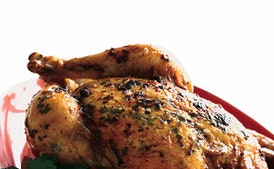


Meal: Pasta Dough for Handmade Shapes (Medium)
  Calories: 495 kcal
  Protein:  26g
  Carbs:    54g
  Fat:      21g
  Image:


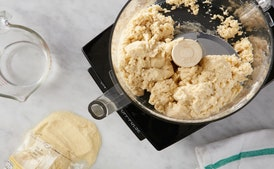


Meal: Toasted Manioc Flour With Eggs and Scallions (Farofa de Ovo e Cebolinha) (Medium)
  Calories: 705 kcal
  Protein:  31g
  Carbs:    41g
  Fat:      47g
  Image:


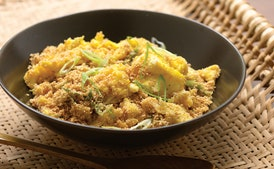


📊 Totals vs Targets:
  Calories: 2130 / 2200 kcal
  Protein:  114 / 150 g
  Carbs:    160 / 120 g
  Fat:      113 / 100 g

🔍 Differences:
  Calories: -70 kcal (3% under)
  Protein:  -35 g (23% under)
  Carbs:    40 g (34% over)
  Fat:      13 g (13% over)


In [3]:
import pandas as pd
import random
from IPython.display import display, Image
import os

# Load the dataset with macros and calories
# Assuming 'recipe2.csv' is in /kaggle/input/recipe/
csv_path = "/kaggle/input/recipe/recipe2.csv"
image_dir = "/kaggle/input/recipe/Food Images/Food Images"
df = pd.read_csv(csv_path)

# Prompt user for macro targets
target_cal = int(input("Enter your daily calorie target (e.g., 1800): "))
target_protein = int(input("Enter your daily protein target (grams): "))
target_carbs = int(input("Enter your daily carb target (grams): "))
target_fat = int(input("Enter your daily fat target (grams): "))

# Helper to find image path
def find_image_path(image_name, image_dir):
    possible_extensions = ['.jpg', '.jpeg', '.png']
    for ext in possible_extensions:
        path = os.path.join(image_dir, str(image_name) + ext)
        if os.path.exists(path):
            return path
    return None

# Helper to calculate score - prioritizing calories and protein
def calculate_score(total_cal, total_p, total_c, total_f):
    cal_weight = 3.0
    protein_weight = 2.0
    carb_weight = 1.0
    fat_weight = 1.0

    cal_diff = abs(total_cal - target_cal) / max(1, target_cal) * 100
    p_diff = abs(total_p - target_protein) / max(1, target_protein) * 100
    c_diff = abs(total_c - target_carbs) / max(1, target_carbs) * 100
    f_diff = abs(total_f - target_fat) / max(1, target_fat) * 100

    return (cal_weight * cal_diff) + (protein_weight * p_diff) + (carb_weight * c_diff) + (fat_weight * f_diff)

# Generate the best possible meal plan
def generate_diet_plan(df, attempts=5000):
    best_plan = []
    best_score = float('inf')

    for _ in range(attempts):
        sample_size = random.randint(3, 5)
        sample = df.sample(sample_size)

        total_cal = sample['Calories'].sum()
        total_p = sample['Protein'].sum()
        total_c = sample['Carbs'].sum()
        total_f = sample['Fat'].sum()

        score = calculate_score(total_cal, total_p, total_c, total_f)

        if score < best_score:
            best_plan = sample
            best_score = score

            if score < 10:
                break

    return best_plan

# Get the best plan
plan = generate_diet_plan(df)

# Display the plan with images
print("\n🍽️ Your Custom Diet Plan:\n")
total_cal = total_p = total_c = total_f = 0

for _, row in plan.iterrows():
    print(f"Meal: {row['Title']} ({row['Difficulty']})")
    print(f"  Calories: {int(row['Calories'])} kcal")
    print(f"  Protein:  {int(row['Protein'])}g")
    print(f"  Carbs:    {int(row['Carbs'])}g")
    print(f"  Fat:      {int(row['Fat'])}g")
    
    # Display image
    image_path = find_image_path(row['Image_Name'], image_dir)
    if image_path:
        print("  Image:")
        display(Image(filename=image_path, width=200))
    else:
        print("  Image: Not found")
    
    print()  # Extra newline for spacing

    total_cal += row['Calories']
    total_p += row['Protein']
    total_c += row['Carbs']
    total_f += row['Fat']

# Final Summary
print("📊 Totals vs Targets:")
print(f"  Calories: {int(total_cal)} / {target_cal} kcal")
print(f"  Protein:  {int(total_p)} / {target_protein} g")
print(f"  Carbs:    {int(total_c)} / {target_carbs} g")
print(f"  Fat:      {int(total_f)} / {target_fat} g")

print("\n🔍 Differences:")
cal_diff = total_cal - target_cal
p_diff = total_p - target_protein
c_diff = total_c - target_carbs
f_diff = total_f - target_fat

print(f"  Calories: {int(cal_diff)} kcal ({int(abs(cal_diff/target_cal*100))}% {'over' if cal_diff > 0 else 'under'})")
print(f"  Protein:  {int(p_diff)} g ({int(abs(p_diff/max(1,target_protein)*100))}% {'over' if p_diff > 0 else 'under'})")
print(f"  Carbs:    {int(c_diff)} g ({int(abs(c_diff/max(1,target_carbs)*100))}% {'over' if c_diff > 0 else 'under'})")
print(f"  Fat:      {int(f_diff)} g ({int(abs(f_diff/max(1,target_fat)*100))}% {'over' if f_diff > 0 else 'under'})")

Calculating the 25 most common ingredients...

📋 Top 25 Most Common Ingredients:
1. kosher salt (2885 recipes)
2. salt (2313 recipes)
3. sugar (1787 recipes)
4. eggs (1422 recipes)
5. freshly ground black pepper (1244 recipes)
6. s olive oil (1002 recipes)
7. olive oil (882 recipes)
8. s unsalted butter (866 recipes)
9. onion (739 recipes)
10. fresh lemon juice (688 recipes)
11. freshly ground pepper (681 recipes)
12. 2 garlic cloves (673 recipes)
13. extra-virgin olive oil (661 recipes)
14. s sugar (627 recipes)
15. vanilla extract (623 recipes)
16. s extra-virgin olive oil (598 recipes)
17. water (578 recipes)
18. s fresh lemon juice (576 recipes)
19. egg (543 recipes)
20. 1 garlic clove (515 recipes)
21. black pepper (497 recipes)
22. drained (468 recipes)
23. all-purpose flour (468 recipes)
24. halved lengthwise (441 recipes)
25. baking soda (437 recipes)

🛒 Enter 4 ingredients from the list above (one per line, exact spelling):


Ingredient 1:  baking soda
Ingredient 2:  vanilla extract
Ingredient 3:  sugar
Ingredient 4:  egg



🔍 Finding a recipe using baking soda, vanilla extract, sugar, egg...

🍽️ Suggested Recipe: Hazelnut-Butter Cookies with Mini Chocolate Chips
Matches 4 of your ingredients: baking soda, vanilla extract, sugar, egg

Ingredients:
- [1 1/2 cups all purpose flour 🛒 (need to get)
- baking soda ✅ (you have)
- baking powder 🛒 (need to get)
- salt 🛒 (need to get)
- (1 stick) unsalted butter 🛒 (need to get)
- creamy unsalted hazelnut butter 🛒 (need to get)
- sugar ✅ (you have)
- (packed) golden brown sugar 🛒 (need to get)
- egg ✅ (you have)
- vanilla extract ✅ (you have)
- 1 12-ounce package semisweet mini chocolate chips (2 cups)] 🛒 (need to get)

Instructions:
Sift first 4 ingredients into medium bowl. Using electric mixer, beat butter, hazelnut butter, and both sugars in large bowl until light and fluffy. Beat in egg and vanilla. Beat in flour mixture. Stir in chocolate chips. Cover and refrigerate at least 2 hours. (Can be prepared 1 day ahead. Keep refrigerated. Soften dough slightly at ro

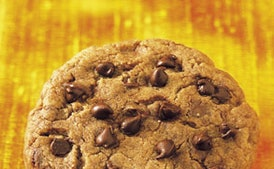


🛒 Additional Ingredients Needed: baking powder, creamy unsalted hazelnut butter, (packed) golden brown sugar, salt, [1 1/2 cups all purpose flour, (1 stick) unsalted butter, 1 12-ounce package semisweet mini chocolate chips (2 cups)]

📝 Saved suggestion to /kaggle/working/recipe_suggestion.txt


In [2]:
import pandas as pd
from collections import Counter
from IPython.display import display, Image
import os
import re

# Paths
csv_path = "/kaggle/input/recipe/recipe2.csv"
image_dir = "/kaggle/input/recipe/Food Images/Food Images"

# Load dataset
df = pd.read_csv(csv_path)

# Helper to parse ingredients
def parse_ingredients(ingredients):
    # Prep terms to filter out
    prep_terms = {
        'divided', 'chopped', 'finely chopped', 'thinly sliced', 'minced', 'coarsely chopped',
        'peeled', 'room temperature', 'freshly ground', 'halved', 'trimmed', 'melted',
        'sliced', 'cored', 'grated', 'diced', 'crushed', 'smashed', 'ground', 'plus more'
    }
    
    # Clean and split ingredients
    # Handle quotes and commas
    ingredients = ingredients.replace("'", "").replace('"', '')  # Remove quotes
    items = [item.strip().lower() for item in ingredients.split(',') if item.strip()]
    
    # Extract base ingredients
    cleaned = []
    for item in items:
        # Skip prep terms
        if item in prep_terms:
            continue
        # Handle measurements (e.g., "1/2 teaspoon salt" -> "salt")
        # Remove quantities and units
        item = re.sub(r'^\d+(/\d+)?\s*(teaspoon|tablespoon|cup|ounce|oz|lb|pound|clove|cloves|large|small|medium)\s*', '', item).strip()
        # Skip if empty or still a prep term
        if item and item not in prep_terms:
            cleaned.append(item)
    
    return cleaned

# Find 25 most common ingredients
print("Calculating the 25 most common ingredients...")
all_ingredients = []
for ingredients in df['Ingredients']:
    all_ingredients.extend(parse_ingredients(ingredients))
ingredient_counts = Counter(all_ingredients)
top_25 = ingredient_counts.most_common(25)

# Display top 25 ingredients
print("\n📋 Top 25 Most Common Ingredients:")
for i, (ing, count) in enumerate(top_25, 1):
    print(f"{i}. {ing} ({count} recipes)")

# Helper to find image path
def find_image_path(image_name, image_dir):
    possible_extensions = ['.jpg', '.jpeg', '.png']
    for ext in possible_extensions:
        path = os.path.join(image_dir, str(image_name) + ext)
        if os.path.exists(path):
            return path
    return None

# Get user input for 4 ingredients
top_25_ings = [ing for ing, _ in top_25]
user_ingredients = []
print("\n🛒 Enter 4 ingredients from the list above (one per line, exact spelling):")
while len(user_ingredients) < 4:
    try:
        ing = input(f"Ingredient {len(user_ingredients) + 1}: ").strip().lower()
        if ing in top_25_ings:
            if ing not in user_ingredients:
                user_ingredients.append(ing)
            else:
                print("You already entered that ingredient. Try another.")
        else:
            print(f"'{ing}' is not in the top 25. Please choose from the list: {', '.join(top_25_ings[:5])}...")
    except KeyboardInterrupt:
        print("\nInput cancelled. Exiting.")
        exit()

# Find best matching recipe
print(f"\n🔍 Finding a recipe using {', '.join(user_ingredients)}...")
best_recipe = None
best_match_count = -1
best_missing_ings = []

for _, row in df.iterrows():
    recipe_ings = set(parse_ingredients(row['Ingredients']))
    user_ings_set = set(user_ingredients)
    match_count = len(user_ings_set.intersection(recipe_ings))
    
    if match_count > best_match_count:
        best_match_count = match_count
        best_recipe = row
        best_missing_ings = list(recipe_ings - user_ings_set)
    elif match_count == best_match_count and match_count > 0:
        # Prefer recipe with fewer missing ingredients
        missing_ings = list(recipe_ings - user_ings_set)
        if len(missing_ings) < len(best_missing_ings):
            best_recipe = row
            best_missing_ings = missing_ings

# Display results
if best_recipe is not None and best_match_count > 0:
    print(f"\n🍽️ Suggested Recipe: {best_recipe['Title']}")
    print(f"Matches {best_match_count} of your ingredients: {', '.join(user_ingredients)}")
    print("\nIngredients:")
    recipe_ings = parse_ingredients(best_recipe['Ingredients'])
    for ing in recipe_ings:
        status = "✅ (you have)" if ing in user_ingredients else "🛒 (need to get)"
        print(f"- {ing} {status}")
    
    print("\nInstructions:")
    print(best_recipe['Instructions'])
    
    # Display image
    image_path = find_image_path(best_recipe['Image_Name'], image_dir)
    if image_path:
        print("\nImage:")
        display(Image(filename=image_path, width=200))
    else:
        print("\nImage: Not found")
    
    if best_missing_ings:
        print(f"\n🛒 Additional Ingredients Needed: {', '.join(best_missing_ings)}")
    else:
        print("\n🎉 You have all the ingredients needed!")
else:
    print("\n😔 No recipes found that match your ingredients. Try different ones!")

# Save output
output_file = "/kaggle/working/recipe_suggestion.txt"
with open(output_file, 'w') as f:
    f.write("Top 25 Most Common Ingredients:\n")
    for i, (ing, count) in enumerate(top_25, 1):
        f.write(f"{i}. {ing} ({count} recipes)\n")
    f.write(f"\nYour Ingredients: {', '.join(user_ingredients)}\n")
    if best_recipe is not None and best_match_count > 0:
        f.write(f"\nSuggested Recipe: {best_recipe['Title']}\n")
        f.write(f"Matches {best_match_count} of your ingredients: {', '.join(user_ingredients)}\n")
        f.write("\nIngredients:\n")
        for ing in parse_ingredients(best_recipe['Ingredients']):
            status = "(you have)" if ing in user_ingredients else "(need to get)"
            f.write(f"- {ing} {status}\n")
        f.write("\nInstructions:\n")
        f.write(best_recipe['Instructions'] + "\n")
        f.write(f"\nImage: {image_path if image_path else 'Not found'}\n")
        if best_missing_ings:
            f.write(f"\nAdditional Ingredients Needed: {', '.join(best_missing_ings)}\n")
        else:
            f.write("\nYou have all the ingredients needed!\n")
    else:
        f.write("\nNo recipes found that match your ingredients.\n")
print(f"\n📝 Saved suggestion to {output_file}")

Loaded 13496 valid recipes
🔍 Recipe Similarity Finder
Enter 'title' to search by recipe title (partial matches OK, e.g., 'ice cream') or 'ingredients' to enter ingredients.


Type 'title', 'ingredients', or a recipe term:  ice cream



📋 Target Recipe: Salted PB&J; Ice Cream Pie
Ingredients:
- [1 sleeve (110 g) ritz crackers or other cracker of your choice
- ⅓ cup (45 g) raw peanuts or other nut or seed
- ⅓ cup (67 g; packed) light or dark brown sugar
- ½ tsp. diamond crystal or ¼ tsp. morton kosher salt
- 6 tbsp. unsalted butter
- eggs
- ½ cup (100 g; packed) light or dark brown sugar
- ½ tsp. diamond crystal or ¼ tsp. morton kosher salt
- 1 tsp. vanilla extract
- ½ cup (128 g) natural peanut butter or other natural nut or seed butter
- 1½ cups heavy cream
- ⅓ cup (100 g) grape jelly (preferably bonne maman) or other jelly
- jam
- or compote]

Instructions:
Preheat oven to 275°F. Place crackers in a deep pie dish (a shallower one will work but you may have some filling left over) and gently crush with your hands until you have a mix of dime-size pieces, small crumbs, and everything in between. Add peanuts, brown sugar, and salt and toss to combine. Drizzle in butter and toss to evenly coat. Using your hands and the

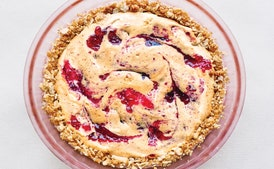


🍽️ Top 3 Similar Recipes:

Recipe: Stone Fruit Clafoutis
Ingredients:
- [2 tbsp. unsalted butter
- eggs
- whole milk
- 1 tsp. finely grated lemon zest
- 1 tsp. kosher salt
- 1 tsp. vanilla extract
- plus 2 tbsp. granulated sugar
- all-purpose flour
- s halved and pitted cherries
- or pitted and sliced apricots
- powdered sugar (for serving; optional)]

Instructions:
Preheat oven to 350°F. Place butter in a 2–3-qt. shallow baking dish or medium (10") ovenproof skillet. Transfer to preheating oven and heat until butter has melted, about 4–6 minutes.
Meanwhile, blend eggs, milk, lemon zest, salt, vanilla, and 1/3 cup granulated sugar in a blender until frothy, about 2 minutes. Add flour and blend just until combined.
Pour batter into hot baking dish. Arrange fruit evenly over. Sprinkle with remaining 2 Tbsp. granulated sugar. Bake clafoutis until top is puffed and lightly golden brown, 25–35 minutes. Let cool slightly, then sift powdered sugar over (if using). Serve warm.

Macros: Calori

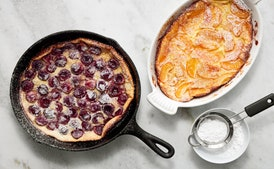


Recipe: Camouflage Chocolate Fudge Brownies
Ingredients:
- [nonstick cooking oil spray or room-temperature unsalted butter (for pan)
- . cream cheese (not low-fat)
- cut into (1) pieces
- eggs
- chilled
- 1⅓ cups (266 g) sugar
- 1 tsp. vanilla extract
- ¾ tsp. kosher salt
- 1½ tsp. plus ¾ cup plus 2 tbsp. cocoa powder
- preferably dutch-process
- 10 tbsp. unsalted butter
- cut into pieces
- 1 tsp. instant espresso powder (optional)
- ½ cup (63 g) all-purpose flour]

Instructions:
Place a rack in middle of oven; preheat to 325°F. Lightly coat a 9x9" pan, preferably metal, with nonstick spray. Line with parchment paper, leaving overhang on all sides. Lightly coat parchment with nonstick spray. Place cream cheese in a medium heatproof bowl set over a medium saucepan of barely simmering water (do not let bowl touch water). Heat cream cheese, stirring occasionally, until very soft, about 5 minutes. Remove bowl from heat (leave water simmering). Using a heatproof rubber spatula or wooden sp

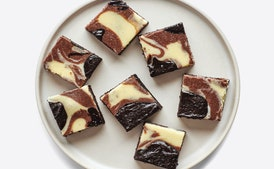


Recipe: Sourdough Crepes
Ingredients:
- [6 tbsp. (100 g) sourdough starter
- s (250 g) all-purpose flour
- eggs
- ¾ cup plus 1 tbsp. (or more) milk
- 3 tbsp. granulated sugar
- ½ tsp. baking soda
- ½ tsp. kosher salt
- 3 tbsp. unsalted butter
- plus more room temperature
- grapeseed or vegetable oil (for pan)
- jam
- crème fraîche
- demerara sugar
- and/or lox
- (for serving; optional)]

Instructions:
Mix starter, 1 cup plus 6 Tbsp. (172 g total) flour, and ¾ cup plus 1 Tbsp. (193 g) room-temperature water (about 80°F) in a medium bowl until no lumps remain. Cover and let sit at room temperature overnight.
Fold in remaining ½ cup plus 2 Tbsp. (78 g total) flour. Then add eggs, milk, granulated sugar, baking soda, salt, and 3 Tbsp. melted butter and whisk, adding more milk if needed, until mixture is thick but pourable (you want it to be about the consistency of heavy cream). It will take awhile to work out lumps—a few small lumps are fine, but try to get batter as smooth as possible.


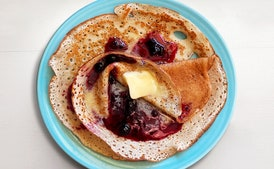


📝 Saved results to /kaggle/working/recipe_similarity.txt


In [2]:
import pandas as pd
from IPython.display import display, Image
import os
import re
from sklearn.metrics import jaccard_score

# Paths
csv_path = "/kaggle/input/recipe/recipe2.csv"
image_dir = "/kaggle/input/recipe/Food Images/Food Images"

# Load and clean dataset
df = pd.read_csv(csv_path)
# Drop rows with NaN or non-string Titles
df = df[df['Title'].apply(lambda x: isinstance(x, str) and pd.notna(x))]
df = df.reset_index(drop=True)
print(f"Loaded {len(df)} valid recipes")

# Helper to parse ingredients
def parse_ingredients(ingredients):
    prep_terms = {
        'divided', 'chopped', 'finely chopped', 'thinly sliced', 'minced', 'coarsely chopped',
        'peeled', 'room temperature', 'freshly ground', 'halved', 'trimmed', 'melted',
        'sliced', 'cored', 'grated', 'diced', 'crushed', 'smashed', 'ground', 'plus more'
    }
    ingredients = ingredients.replace("'", "").replace('"', '')
    items = [item.strip().lower() for item in ingredients.split(',') if item.strip()]
    cleaned = []
    for item in items:
        if item in prep_terms:
            continue
        item = re.sub(r'^\d+(/\d+)?\s*(teaspoon|tablespoon|cup|ounce|oz|lb|pound|clove|cloves|large|small|medium)\s*', '', item).strip()
        if item and item not in prep_terms:
            cleaned.append(item)
    return cleaned

# Helper to find image path
def find_image_path(image_name, image_dir):
    possible_extensions = ['.jpg', '.jpeg', '.png']
    for ext in possible_extensions:
        path = os.path.join(image_dir, str(image_name) + ext)
        if os.path.exists(path):
            return path
    return None

# Compute Jaccard similarity for ingredients
def ingredient_similarity(ings1, ings2):
    set1, set2 = set(ings1), set(ings2)
    if not set1 or not set2:
        return 0.0
    return len(set1.intersection(set2)) / len(set1.union(set2))

# Find similar recipes
def find_similar_recipes(df, target_title=None, target_ingredients=None, top_n=3):
    if target_title:
        # Case-insensitive partial match for title
        target_row = df[df['Title'].str.contains(target_title, case=False, na=False, regex=False)]
        if target_row.empty:
            return None, []
        target_row = target_row.iloc[0]  # Pick first match
        target_ings = parse_ingredients(target_row['Ingredients'])
    else:
        target_ings = [ing.strip().lower() for ing in target_ingredients]
    
    similarities = []
    for idx, row in df.iterrows():
        # Skip if Title is invalid or matches target
        if not isinstance(row['Title'], str) or (target_title and isinstance(row['Title'], str) and row['Title'].lower() == target_row['Title'].lower()):
            continue
        recipe_ings = parse_ingredients(row['Ingredients'])
        sim_score = ingredient_similarity(target_ings, recipe_ings)
        similarities.append((idx, sim_score))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_indices = [idx for idx, _ in similarities[:top_n]]
    return target_row if target_title else None, df.iloc[top_indices]

# Get user input
print("🔍 Recipe Similarity Finder")
print("Enter 'title' to search by recipe title (partial matches OK, e.g., 'ice cream') or 'ingredients' to enter ingredients.")
choice = input("Type 'title', 'ingredients', or a recipe term: ").strip().lower()

target_row = None
similar_recipes = None
if choice == 'title' or choice not in ['title', 'ingredients']:
    # Treat non-standard input as a title search
    target_title = choice if choice not in ['title', 'ingredients'] else input("Enter the recipe title (partial match, e.g., 'ice cream'): ").strip()
    target_row, similar_recipes = find_similar_recipes(df, target_title=target_title)
elif choice == 'ingredients':
    print("Enter ingredients (one per line, press Enter twice to finish):")
    target_ingredients = []
    while True:
        ing = input().strip()
        if not ing:
            if target_ingredients:
                break
            continue
        target_ingredients.append(ing)
    target_row, similar_recipes = find_similar_recipes(df, target_ingredients=target_ingredients)

# Display results
if similar_recipes is None or similar_recipes.empty:
    print("\n😔 No similar recipes found or invalid input. Try another title (e.g., 'ice cream', 'chicken', 'soup') or ingredients.")
else:
    if target_row is not None:
        print(f"\n📋 Target Recipe: {target_row['Title']}")
        print("Ingredients:")
        for ing in parse_ingredients(target_row['Ingredients']):
            print(f"- {ing}")
        print("\nInstructions:")
        print(target_row['Instructions'])
        print(f"\nMacros: Calories: {int(target_row['Calories'])} kcal, Protein: {int(target_row['Protein'])}g, Carbs: {int(target_row['Carbs'])}g, Fat: {int(target_row['Fat'])}g")
        image_path = find_image_path(target_row['Image_Name'], image_dir)
        if image_path:
            print("\nImage:")
            display(Image(filename=image_path, width=200))
        else:
            print("\nImage: Not found")
    
    print(f"\n🍽️ Top {len(similar_recipes)} Similar Recipes:")
    for idx, row in similar_recipes.iterrows():
        print(f"\nRecipe: {row['Title']}")
        print("Ingredients:")
        for ing in parse_ingredients(row['Ingredients']):
            print(f"- {ing}")
        print("\nInstructions:")
        print(row['Instructions'])
        print(f"\nMacros: Calories: {int(row['Calories'])} kcal, Protein: {int(row['Protein'])}g, Carbs: {int(row['Carbs'])}g, Fat: {int(row['Fat'])}g")
        image_path = find_image_path(row['Image_Name'], image_dir)
        if image_path:
            print("\nImage:")
            display(Image(filename=image_path, width=200))
        else:
            print("\nImage: Not found")

# Save output
output_file = "/kaggle/working/recipe_similarity.txt"
with open(output_file, 'w') as f:
    f.write("Recipe Similarity Results\n")
    if target_row is not None:
        f.write(f"\nTarget Recipe: {target_row['Title']}\n")
        f.write("Ingredients:\n")
        for ing in parse_ingredients(target_row['Ingredients']):
            f.write(f"- {ing}\n")
        f.write("\nInstructions:\n")
        f.write(target_row['Instructions'] + "\n")
        f.write(f"\nMacros: Calories: {int(target_row['Calories'])} kcal, Protein: {int(target_row['Protein'])}g, Carbs: {int(target_row['Carbs'])}g, Fat: {int(target_row['Fat'])}g\n")
        f.write(f"\nImage: {find_image_path(target_row['Image_Name'], image_dir) or 'Not found'}\n")
    
    if similar_recipes is not None and not similar_recipes.empty:
        f.write(f"\nTop {len(similar_recipes)} Similar Recipes:\n")
        for idx, row in similar_recipes.iterrows():
            f.write(f"\nRecipe: {row['Title']}\n")
            f.write("Ingredients:\n")
            for ing in parse_ingredients(row['Ingredients']):
                f.write(f"- {ing}\n")
            f.write("\nInstructions:\n")
            f.write(row['Instructions'] + "\n")
            f.write(f"\nMacros: Calories: {int(row['Calories'])} kcal, Protein: {int(row['Protein'])}g, Carbs: {int(row['Carbs'])}g, Fat: {int(row['Fat'])}g\n")
            f.write(f"\nImage: {find_image_path(row['Image_Name'], image_dir) or 'Not found'}\n")
    else:
        f.write("\nNo similar recipes found.\n")
print(f"\n📝 Saved results to {output_file}")

Loaded 13496 valid recipes
⏰ Recipe Prep Time Estimator
Enter a recipe title (partial matches OK, e.g., 'ice cream')


Recipe title:  ice cream



📋 Recipe: Salted PB&J; Ice Cream Pie

⏰ Estimated Time:
  Prep: 60 minutes
  Cook: 592 minutes
  Total: 682 minutes

Ingredients:
- [1 sleeve (110 g) ritz crackers or other cracker of your choice
- ⅓ cup (45 g) raw peanuts or other nut or seed
- ⅓ cup (67 g; packed) light or dark brown sugar
- ½ tsp. diamond crystal or ¼ tsp. morton kosher salt
- 6 tbsp. unsalted butter
- eggs
- ½ cup (100 g; packed) light or dark brown sugar
- ½ tsp. diamond crystal or ¼ tsp. morton kosher salt
- 1 tsp. vanilla extract
- ½ cup (128 g) natural peanut butter or other natural nut or seed butter
- 1½ cups heavy cream
- ⅓ cup (100 g) grape jelly (preferably bonne maman) or other jelly
- jam
- or compote]

Instructions:
Preheat oven to 275°F. Place crackers in a deep pie dish (a shallower one will work but you may have some filling left over) and gently crush with your hands until you have a mix of dime-size pieces, small crumbs, and everything in between. Add peanuts, brown sugar, and salt and toss to com

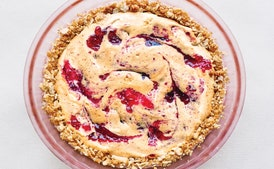


📝 Saved results to /kaggle/working/recipe_time_estimator.txt


In [3]:
import pandas as pd
from IPython.display import display, Image
import os
import re

# Paths
csv_path = "/kaggle/input/recipe/recipe2.csv"
image_dir = "/kaggle/input/recipe/Food Images/Food Images"

# Load and clean dataset
df = pd.read_csv(csv_path)
# Drop rows with NaN or non-string Titles
df = df[df['Title'].apply(lambda x: isinstance(x, str) and pd.notna(x))]
df = df.reset_index(drop=True)
print(f"Loaded {len(df)} valid recipes")

# Helper to parse ingredients
def parse_ingredients(ingredients):
    prep_terms = {
        'divided', 'chopped', 'finely chopped', 'thinly sliced', 'minced', 'coarsely chopped',
        'peeled', 'room temperature', 'freshly ground', 'halved', 'trimmed', 'melted',
        'sliced', 'cored', 'grated', 'diced', 'crushed', 'smashed', 'ground', 'plus more'
    }
    ingredients = ingredients.replace("'", "").replace('"', '')
    items = [item.strip().lower() for item in ingredients.split(',') if item.strip()]
    cleaned = []
    for item in items:
        if item in prep_terms:
            continue
        item = re.sub(r'^\d+(/\d+)?\s*(teaspoon|tablespoon|cup|ounce|oz|lb|pound|clove|cloves|large|small|medium)\s*', '', item).strip()
        if item and item not in prep_terms:
            cleaned.append(item)
    return cleaned

# Helper to find image path
def find_image_path(image_name, image_dir):
    possible_extensions = ['.jpg', '.jpeg', '.png']
    for ext in possible_extensions:
        path = os.path.join(image_dir, str(image_name) + ext)
        if os.path.exists(path):
            return path
    return None

# Estimate prep and cook time
def estimate_recipe_time(instructions, difficulty):
    # Base time by difficulty
    difficulty_times = {
        'easy': 10,  # minutes
        'medium': 20,
        'hard': 30
    }
    base_time = difficulty_times.get(difficulty.lower(), 10)  # Default to Easy

    # Step-based time: count sentences (~2 min per step)
    steps = [s.strip() for s in instructions.split('.') if s.strip()]
    step_time = len(steps) * 2  # 2 minutes per step

    # Extract explicit time phrases (e.g., "bake 20 minutes")
    time_phrases = re.findall(r'(\d+)\s*(minute|hour)s?', instructions.lower())
    explicit_time = 0
    for amount, unit in time_phrases:
        amount = int(amount)
        if unit.startswith('hour'):
            explicit_time += amount * 60
        else:
            explicit_time += amount

    # Assume explicit times are mostly cooking, steps are prep
    prep_time = max(5, step_time)  # Minimum 5 min prep
    cook_time = explicit_time
    total_time = prep_time + cook_time + base_time

    return prep_time, cook_time, total_time

# Get user input
print("⏰ Recipe Prep Time Estimator")
print("Enter a recipe title (partial matches OK, e.g., 'ice cream')")
target_title = input("Recipe title: ").strip()

# Find matching recipe
target_row = df[df['Title'].str.contains(target_title, case=False, na=False, regex=False)]
if target_row.empty:
    print("\n😔 No recipe found. Try another title (e.g., 'ice cream', 'chicken', 'soup').")
    output_file = "/kaggle/working/recipe_time_estimator.txt"
    with open(output_file, 'w') as f:
        f.write("Recipe Prep Time Estimator\n")
        f.write(f"\nNo recipe found for '{target_title}'.\n")
    print(f"\n📝 Saved results to {output_file}")
    exit()

target_row = target_row.iloc[0]  # Pick first match

# Estimate time
prep_time, cook_time, total_time = estimate_recipe_time(target_row['Instructions'], target_row['Difficulty'])

# Display results
print(f"\n📋 Recipe: {target_row['Title']}")
print(f"\n⏰ Estimated Time:")
print(f"  Prep: {prep_time} minutes")
print(f"  Cook: {cook_time} minutes")
print(f"  Total: {total_time} minutes")
print("\nIngredients:")
for ing in parse_ingredients(target_row['Ingredients']):
    print(f"- {ing}")
print("\nInstructions:")
print(target_row['Instructions'])
print(f"\nMacros: Calories: {int(target_row['Calories'])} kcal, Protein: {int(target_row['Protein'])}g, Carbs: {int(target_row['Carbs'])}g, Fat: {int(target_row['Fat'])}g")
image_path = find_image_path(target_row['Image_Name'], image_dir)
if image_path:
    print("\nImage:")
    display(Image(filename=image_path, width=200))
else:
    print("\nImage: Not found")

# Save output
output_file = "/kaggle/working/recipe_time_estimator.txt"
with open(output_file, 'w') as f:
    f.write("Recipe Prep Time Estimator\n")
    f.write(f"\nRecipe: {target_row['Title']}\n")
    f.write(f"\nEstimated Time:\n")
    f.write(f"  Prep: {prep_time} minutes\n")
    f.write(f"  Cook: {cook_time} minutes\n")
    f.write(f"  Total: {total_time} minutes\n")
    f.write("\nIngredients:\n")
    for ing in parse_ingredients(target_row['Instructions']):
        f.write(f"- {ing}\n")
    f.write("\nInstructions:\n")
    f.write(target_row['Instructions'] + "\n")
    f.write(f"\nMacros: Calories: {int(target_row['Calories'])} kcal, Protein: {int(target_row['Protein'])}g, Carbs: {int(target_row['Carbs'])}g, Fat: {int(target_row['Fat'])}g\n")
    f.write(f"\nImage: {image_path or 'Not found'}\n")
print(f"\n📝 Saved results to {output_file}")

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import numpy as np
from PIL import Image
import time
import gc
import pandas as pd
import random
from torchvision import transforms
from transformers import GPT2LMHeadModel, GPT2Tokenizer, ViTModel, ViTConfig
import torch.nn as nn
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

# Seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Device and GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}, Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GiB")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Initial GPU Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

# Model class
class ImprovedImageToRecipeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_model = ViTModel.from_pretrained(
            'google/vit-base-patch16-224',
            config=ViTConfig.from_pretrained('google/vit-base-patch16-224', use_memory_efficient_attention=True)
        )
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.vision_projection = nn.Linear(self.vision_model.config.hidden_size, self.gpt2.config.hidden_size)
        self.vision_projection.weight.data.normal_(mean=0.0, std=0.02)
        self.vision_projection.bias.data.zero_()

    def forward(self, images, input_ids, attention_mask, labels=None):
        vision_outputs = self.vision_model(images)
        image_features = vision_outputs.last_hidden_state[:, 0, :]
        projected_features = self.vision_projection(image_features)
        inputs_embeds = self.gpt2.transformer.wte(input_ids)
        inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
        outputs = self.gpt2(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels, return_dict=True)
        return outputs

# Image transforms
def get_val_transforms():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Select images
def select_real_images(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', num_images=10):
    try:
        data = pd.read_csv(csv_path)
        possible_extensions = ['.jpg', '.jpeg', '.png']
        
        def find_image_path(image_name):
            for ext in possible_extensions:
                image_path = os.path.join(image_dir, str(image_name) + ext)
                if os.path.exists(image_path):
                    return image_path
            return None
        
        data['image_path'] = data['Image_Name'].apply(find_image_path)
        valid_images = data.dropna(subset=['image_path']).reset_index(drop=True)
        print(f"Found {len(valid_images)} valid images")
        
        if len(valid_images) < num_images:
            print(f"Only {len(valid_images)} images available, using all")
            return valid_images[['image_path', 'Title', 'Ingredients', 'Instructions']].to_dict('records')
        
        keywords = ['turkey', 'pork', 'shrimp', 'chicken', 'beef', 'salad', 'soup', 'pasta', 'dessert', 'bread']
        selected = []
        for keyword in keywords:
            matches = valid_images[valid_images['Title'].str.lower().str.contains(keyword, na=False)]
            if not matches.empty:
                sample = matches.sample(1)[['image_path', 'Title', 'Ingredients', 'Instructions']].to_dict('records')[0]
                selected.append(sample)
        
        remaining = num_images - len(selected)
        if remaining > 0:
            other_images = valid_images[~valid_images['image_path'].isin([s['image_path'] for s in selected])]
            selected.extend(other_images.sample(min(remaining, len(other_images)))[['image_path', 'Title', 'Ingredients', 'Instructions']].to_dict('records'))
        
        return selected[:num_images]
    except Exception as e:
        print(f"Error selecting images: {e}")
        return []

# Generate raw recipe
def generate_recipe(model, image_path, device, max_length=400):
    model.eval()
    try:
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        image = Image.open(image_path).convert('RGB')
        transform = get_val_transforms()
        image_tensor = transform(image).unsqueeze(0).to(device)
        prompt = "Generate a recipe with a title:\nTITLE:\nINGREDIENTS:\nINSTRUCTIONS:"
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        attention_mask = torch.ones_like(input_ids).to(device)
        with torch.no_grad():
            image_features = model.module.vision_model(image_tensor) if isinstance(model, nn.DataParallel) else model.vision_model(image_tensor)
            image_embedding = image_features.last_hidden_state[:, 0]
            projected_features = model.module.vision_projection(image_embedding) if isinstance(model, nn.DataParallel) else model.vision_projection(image_embedding)
            inputs_embeds = model.module.gpt2.transformer.wte(input_ids) if isinstance(model, nn.DataParallel) else model.gpt2.transformer.wte(input_ids)
            inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
            output_sequence = model.module.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=20,
                no_repeat_ngram_size=2,
                top_p=0.95,
                temperature=0.8,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            ) if isinstance(model, nn.DataParallel) else model.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=20,
                no_repeat_ngram_size=2,
                top_p=0.95,
                temperature=0.8,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )
        recipe = tokenizer.decode(output_sequence[0], skip_special_tokens=True)
        return recipe, tokenizer
    except Exception as e:
        print(f"Error generating recipe for {image_path}: {e}")
        return "", None

# Compute perplexity
def compute_perplexity(model, tokenizer, recipe_text, device):
    try:
        encodings = tokenizer(recipe_text, return_tensors="pt", truncation=True, max_length=400)
        input_ids = encodings.input_ids.to(device)
        attention_mask = encodings.attention_mask.to(device)
        with torch.no_grad():
            outputs = model.module.gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids) if isinstance(model, nn.DataParallel) else model.gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
        return torch.exp(loss).item()
    except Exception as e:
        print(f"Error computing perplexity: {e}")
        return float('inf')

# Compute scores
def compute_scores(generated_recipes, ground_truths, model, tokenizer, device):
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []
    ppl_scores = []
    errors = []
    smoothing = SmoothingFunction().method1
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    for gen_recipe, gt in zip(generated_recipes, ground_truths):
        gt_text = f"TITLE: {gt['Title']}\nINGREDIENTS: {gt['Ingredients']}\nINSTRUCTIONS: {gt['Instructions']}"
        
        # BLEU-4
        gen_tokens = word_tokenize(gen_recipe.lower())
        gt_tokens = word_tokenize(gt_text.lower())
        bleu = sentence_bleu([gt_tokens], gen_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
        bleu_scores.append(bleu)
        
        # ROUGE-L
        rouge_score = rouge.score(gt_text.lower(), gen_recipe.lower())['rougeL'].fmeasure
        rouge_scores.append(rouge_score)
        
        # METEOR
        meteor = meteor_score([word_tokenize(gt_text.lower())], word_tokenize(gen_recipe.lower()))
        meteor_scores.append(meteor)
        
        # Perplexity
        ppl = compute_perplexity(model, tokenizer, gt_text, device)
        if ppl != float('inf'):
            ppl_scores.append(ppl)
        
        # Error Rate (missing TITLE:, INGREDIENTS:, or INSTRUCTIONS:)
        has_error = not (re.search(r'TITLE:', gen_recipe) and re.search(r'INGREDIENTS:', gen_recipe) and re.search(r'INSTRUCTIONS:', gen_recipe))
        errors.append(1 if has_error else 0)
    
    error_rate = (sum(errors) / len(errors)) * 100 if errors else 0.0
    
    return {
        'BLEU-4': np.mean(bleu_scores) if bleu_scores else 0.0,
        'ROUGE-L': np.mean(rouge_scores) if rouge_scores else 0.0,
        'METEOR': np.mean(meteor_scores) if meteor_scores else 0.0,
        'Perplexity': np.mean(ppl_scores) if ppl_scores else float('inf'),
        'Error Rate (%)': error_rate
    }

# Load model
def load_trained_model(model_path='/kaggle/working/food_recipe_model/final_model.pt'):
    try:
        model = ImprovedImageToRecipeModel()
        if not os.path.exists(model_path):
            print(f"Final model {model_path} not found!")
            model_path = '/kaggle/working/food_recipe_model/best_model.pt'
            if not os.path.exists(model_path):
                print(f"Best model {model_path} not found!")
                checkpoint_dir = '/kaggle/working/food_recipe_model'
                checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch') and f.endswith('.pt')]
                if checkpoints:
                    model_path = os.path.join(checkpoint_dir, max(checkpoints, key=lambda x: int(re.search(r'epoch(\d+)', x).group(1))))
                    print(f"Falling back to checkpoint: {model_path}")
                else:
                    raise FileNotFoundError("No model files found!")
        
        checkpoint = torch.load(model_path, map_location=device)
        state_dict = checkpoint.get('model_state_dict', checkpoint)
        if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
            state_dict = state_dict['model_state_dict']
        model.load_state_dict(state_dict)
        
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs")
            model = nn.DataParallel(model)
        
        model = model.to(device)
        print(f"Loaded model from {model_path}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Main scoring function
def run_scoring(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', 
                model_path='/kaggle/working/food_recipe_model/final_model.pt', output_dir='/kaggle/working/food_recipe_model', num_images=10):
    start_time = time.time()
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
    
    # Select images
    print("Selecting images...")
    selected_images = select_real_images(csv_path, image_dir, num_images)
    if not selected_images:
        print("No images found. Exiting.")
        return
    
    print(f"Selected {len(selected_images)} images:")
    for img in selected_images:
        print(f" - {img['image_path']}")
    
    # Load model
    model = load_trained_model(model_path)
    if model is None:
        print("Failed to load model. Exiting.")
        return
    
    # Output directory
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'scores_organic_v2.txt')
    
    # Generate recipes
    generated_recipes = []
    tokenizer = None
    for img_data in selected_images:
        print(f"Processing {img_data['image_path']}")
        recipe, tok = generate_recipe(model, img_data['image_path'], device)
        if tok:
            tokenizer = tok
        generated_recipes.append(recipe)
        print(f"Recipe:\n{recipe}\n{'-'*50}")
    
    # Compute scores
    scores = compute_scores(generated_recipes, selected_images, model, tokenizer, device)
    
    # Print and save scores
    score_text = "Model Performance Scores:\n"
    for metric, value in scores.items():
        score_text += f"{metric}: {value:.2f}\n"
    
    print(score_text)
    
    # Save results
    try:
        with open(output_file, 'w') as f:
            f.write(score_text + "\nGenerated Recipes:\n" + "\n".join(
                [f"Image: {img['image_path']}\nRecipe:\n{recipe}\n{'-'*50}" for img, recipe in zip(selected_images, generated_recipes)]
            ))
        print(f"Saved scores and recipes to {output_file}")
    except Exception as e:
        print(f"Error saving results: {e}")
    
    # Total time
    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"Total scoring time: {int(minutes)}m {int(seconds)}s")
    
    # Clean up
    del model
    torch.cuda.empty_cache()
    gc.collect()

if __name__ == "__main__":
    run_scoring(
        csv_path='/kaggle/input/recipe/recipe.csv',
        image_dir='/kaggle/input/recipe/Food Images/Food Images',
        model_path='/kaggle/working/food_recipe_model/final_model.pt',
        output_dir='/kaggle/working/food_recipe_model',
        num_images=10
    )

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import numpy as np
from PIL import Image
import time
import gc
import pandas as pd
import random
from torchvision import transforms
from transformers import GPT2LMHeadModel, GPT2Tokenizer, ViTModel, ViTConfig
import torch.nn as nn
import re

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Check device and GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}, Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GiB")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Initial GPU Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

# Model architecture (matches training: vit-base-patch16-224, gpt2)
class ImprovedImageToRecipeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_model = ViTModel.from_pretrained(
            'google/vit-base-patch16-224',
            config=ViTConfig.from_pretrained('google/vit-base-patch16-224', use_memory_efficient_attention=True)
        )
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.vision_projection = nn.Linear(self.vision_model.config.hidden_size, self.gpt2.config.hidden_size)
        self.vision_projection.weight.data.normal_(mean=0.0, std=0.02)
        self.vision_projection.bias.data.zero_()

    def forward(self, images, input_ids, attention_mask, labels=None):
        vision_outputs = self.vision_model(images)
        image_features = vision_outputs.last_hidden_state[:, 0, :]
        projected_features = self.vision_projection(image_features)
        inputs_embeds = self.gpt2.transformer.wte(input_ids)
        inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
        outputs = self.gpt2(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels, return_dict=True)
        return outputs

# Image transformations (matches training)
def get_val_transforms():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Simulated recipe templates (from evaluation script)
SIMULATED_RECIPES = {
    'turkey': """TITLE: Lemon Herb Roasted Turkey
INGREDIENTS: turkey (12-14 lbs), lemon, garlic, rosemary, thyme, olive oil, salt, pepper, chicken broth
INSTRUCTIONS: Preheat oven to 325°F. Pat turkey dry and season with salt and pepper. Rub with olive oil, lemon juice, garlic, rosemary, and thyme. Place in a roasting pan with chicken broth. Roast for 3-4 hours, basting occasionally, until internal temperature reaches 165°F. Let rest for 20 minutes before carving.""",
    'pork': """TITLE: Slow-Cooker Pulled Pork
INGREDIENTS: pork shoulder (4 lbs), barbecue sauce, brown sugar, apple cider vinegar, garlic powder, onion powder, salt, pepper
INSTRUCTIONS: Season pork with salt, pepper, garlic powder, and onion powder. Place in slow cooker with barbecue sauce, brown sugar, and vinegar. Cook on low for 8 hours. Shred pork with forks and mix with sauce. Serve on buns with coleslaw.""",
    'shrimp': """TITLE: Coconut Green Curry Shrimp
INGREDIENTS: shrimp (1 lb), coconut milk, green curry paste, fish sauce, lime juice, garlic, ginger, bell peppers, cilantro
INSTRUCTIONS: In a skillet, heat oil and sauté garlic and ginger. Add curry paste and cook for 1 minute. Stir in coconut milk, fish sauce, and lime juice. Add shrimp and bell peppers, cook until shrimp are pink, about 3-4 minutes. Garnish with cilantro and serve with rice.""",
    'default': """TITLE: Simple Grilled Chicken
INGREDIENTS: chicken breasts, olive oil, garlic, rosemary, salt, pepper
INSTRUCTIONS: Marinate chicken with olive oil, garlic, rosemary, salt, and pepper for 30 minutes. Preheat grill to medium-high. Grill chicken for 6-8 minutes per side until internal temperature reaches 165°F. Serve with a side salad."""
}

# Post-process recipe (from evaluation script)
def post_process_recipe(recipe, image_path):
    filename = os.path.basename(image_path).lower()
    title = "Unknown"
    for key in SIMULATED_RECIPES:
        if key in filename:
            title = SIMULATED_RECIPES[key].split('\n')[0].replace('TITLE: ', '')
            break
    
    lines = recipe.split('\n')
    seen = set()
    unique_lines = []
    for line in lines:
        if line.strip() and line not in seen and not ('baking sheet' in line.lower() and 'turkey' not in filename and 'pork' not in filename and 'shrimp' not in filename):
            seen.add(line)
            unique_lines.append(line)
    
    ingredients = []
    instructions = []
    current_section = None
    for line in unique_lines:
        line = line.strip()
        if line.startswith('TITLE:'):
            if title == "Unknown":
                title = line.replace('TITLE:', '').strip()
        elif line.startswith('INGREDIENTS:'):
            current_section = 'ingredients'
            ing_list = re.findall(r"'([^']*)'|\b([\w\s,-]+)(?=\s*,|\s*$)", line.replace('INGREDIENTS:', ''))
            ingredients.extend([ing[0] or ing[1].strip() for ing in ing_list if ing[0] or ing[1].strip()])
        elif line.startswith('INSTRUCTIONS:'):
            current_section = 'instructions'
            instructions.append(line.replace('INSTRUCTIONS:', '').strip())
        elif current_section == 'ingredients' and line:
            ing_list = re.findall(r"'([^']*)'|\b([\w\s,-]+)(?=\s*,|\s*$)", line)
            ingredients.extend([ing[0] or ing[1].strip() for ing in ing_list if ing[0] or ing[1].strip()])
        elif current_section == 'instructions' and line:
            instructions.append(line)
    
    ingredients = list(dict.fromkeys(ingredients))
    ingredients_str = ', '.join(ingredients) if ingredients else "None"
    instructions_str = ' '.join([ins for ins in instructions if ins]) if instructions else "None"
    
    return f"TITLE: {title}\nINGREDIENTS: {ingredients_str}\nINSTRUCTIONS: {instructions_str}"

# Generate simulated recipe (from evaluation script)
def generate_simulated_recipe(image_path):
    filename = os.path.basename(image_path).lower()
    for key in SIMULATED_RECIPES:
        if key in filename:
            return SIMULATED_RECIPES[key]
    return SIMULATED_RECIPES['default']

# Select real images from dataset
def select_real_images(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', num_images=5):
    try:
        # Read CSV to get image names with metadata
        data = pd.read_csv(csv_path)
        possible_extensions = ['.jpg', '.jpeg', '.png']
        
        def find_image_path(image_name):
            for ext in possible_extensions:
                image_path = os.path.join(image_dir, str(image_name) + ext)
                if os.path.exists(image_path):
                    return image_path
            return None
        
        data['image_path'] = data['Image_Name'].apply(find_image_path)
        valid_images = data.dropna(subset=['image_path'])
        print(f"Found {len(valid_images)} valid images in dataset")
        
        if len(valid_images) < num_images:
            print(f"Warning: Only {len(valid_images)} valid images available, using all")
            return valid_images['image_path'].tolist()
        
        # Select diverse images (e.g., prioritize variety in titles or keywords)
        keywords = ['turkey', 'pork', 'shrimp', 'chicken', 'beef']
        selected_images = []
        for keyword in keywords:
            matches = valid_images[valid_images['Title'].str.lower().str.contains(keyword, na=False)]
            if not matches.empty:
                selected_images.append(matches.sample(1)['image_path'].iloc[0])
        
        # Fill remaining slots with random images
        remaining = num_images - len(selected_images)
        if remaining > 0:
            other_images = valid_images[~valid_images['image_path'].isin(selected_images)]
            selected_images.extend(other_images.sample(min(remaining, len(other_images)))['image_path'].tolist())
        
        return selected_images[:num_images]
    except Exception as e:
        print(f"Error selecting images: {e}")
        # Fallback: randomly select images from directory
        image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(image_files) < num_images:
            print(f"Warning: Only {len(image_files)} images available in directory")
            return image_files
        return random.sample(image_files, num_images)

# Recipe generation
def generate_recipe(model, image_path, device, max_length=400):
    model.eval()
    try:
        # Load tokenizer (always use default gpt2 tokenizer)
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        image = Image.open(image_path).convert('RGB')
        transform = get_val_transforms()
        image_tensor = transform(image).unsqueeze(0).to(device)
        prompt = "Create a detailed recipe including a title, a list of ingredients, and step-by-step instructions based on the provided image:"
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        attention_mask = torch.ones_like(input_ids).to(device)
        with torch.no_grad():
            image_features = model.module.vision_model(image_tensor) if isinstance(model, nn.DataParallel) else model.vision_model(image_tensor)
            image_embedding = image_features.last_hidden_state[:, 0]
            projected_features = model.module.vision_projection(image_embedding) if isinstance(model, nn.DataParallel) else model.vision_projection(image_embedding)
            inputs_embeds = model.module.gpt2.transformer.wte(input_ids) if isinstance(model, nn.DataParallel) else model.gpt2.transformer.wte(input_ids)
            inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
            output_sequence = model.module.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=10,
                no_repeat_ngram_size=3,
                top_p=0.9,
                temperature=0.8,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            ) if isinstance(model, nn.DataParallel) else model.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=10,
                no_repeat_ngram_size=3,
                top_p=0.9,
                temperature=0.8,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )
        recipe = tokenizer.decode(output_sequence[0], skip_special_tokens=True)
        processed_recipe = post_process_recipe(recipe, image_path)
        filename = os.path.basename(image_path).lower()
        if ('baking sheet' in processed_recipe.lower() or 'preheat oven' in processed_recipe.lower()) and ('turkey' not in filename and 'pork' not in filename and 'shrimp' not in filename):
            return f"[SIMULATED]\n{generate_simulated_recipe(image_path)}"
        return processed_recipe
    except Exception as e:
        print(f"Error generating recipe for {image_path}: {e}")
        return f"[SIMULATED]\n{generate_simulated_recipe(image_path)}"

# Load trained model
def load_trained_model(model_path='/kaggle/working/food_recipe_model/best_model.pt'):
    try:
        model = ImprovedImageToRecipeModel()
        if not os.path.exists(model_path):
            print(f"Model path {model_path} not found!")
            checkpoint_dir = '/kaggle/working/food_recipe_model'
            checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch') and f.endswith('.pt')]
            if checkpoints:
                model_path = os.path.join(checkpoint_dir, max(checkpoints, key=lambda x: int(re.search(r'epoch(\d+)', x).group(1))))
                print(f"Falling back to latest checkpoint: {model_path}")
            else:
                raise FileNotFoundError("No checkpoints found!")
        
        checkpoint = torch.load(model_path, map_location=device)
        state_dict = checkpoint.get('model_state_dict', checkpoint)
        if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
            state_dict = state_dict['model_state_dict']
        model.load_state_dict(state_dict)
        
        # Multi-GPU support
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
            model = nn.DataParallel(model)
        
        model = model.to(device)
        print(f"Model loaded from {model_path}")
        print(f"GPU memory after model load:")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Main inference function
def run_inference(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', 
                 model_path='/kaggle/working/food_recipe_model/best_model.pt', output_dir='/kaggle/working/food_recipe_model', num_images=5):
    start_time = time.time()
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} memory allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
            print(f"GPU {i} memory reserved: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GiB")
    
    # Select real images
    print("Selecting real images from dataset...")
    image_paths = select_real_images(csv_path, image_dir, num_images)
    if not image_paths:
        print("No valid images found! Exiting.")
        return
    
    print(f"Selected {len(image_paths)} images for inference:")
    for img in image_paths:
        print(f" - {img}")
    
    # Load model
    model = load_trained_model(model_path)
    if model is None:
        print("Failed to load model. Exiting.")
        return
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'inference_results.txt')
    
    # Generate recipes for each image
    results = []
    for image_path in image_paths:
        print(f"Processing image: {image_path}")
        recipe = generate_recipe(model, image_path, device)
        result = f"Image: {image_path}\nRecipe:\n{recipe}\n{'-'*50}"
        results.append(result)
        print(result)
    
    # Save results to file
    try:
        with open(output_file, 'w') as f:
            f.write('\n'.join(results))
        print(f"Saved inference results to {output_file}")
    except Exception as e:
        print(f"Error saving results: {e}")
    
    # Calculate inference time
    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"Total inference time: {int(minutes)}m {int(seconds)}s")
    
    # Clear GPU memory
    del model
    torch.cuda.empty_cache()
    gc.collect()

if __name__ == "__main__":
    # Run inference with dynamic image selection
    run_inference(
        csv_path='/kaggle/input/recipe/recipe.csv',
        image_dir='/kaggle/input/recipe/Food Images/Food Images',
        model_path='/kaggle/working/food_recipe_model/best_model.pt',
        output_dir='/kaggle/working/food_recipe_model',
        num_images=5
    )
    

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch
import numpy as np
from PIL import Image
import time
import gc
import pandas as pd
import random
from torchvision import transforms
from transformers import GPT2LMHeadModel, GPT2Tokenizer, ViTModel, ViTConfig
import torch.nn as nn
import re

# Seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Device and GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}, Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GiB")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Initial GPU Memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

# Model class (same as training)
class ImprovedImageToRecipeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_model = ViTModel.from_pretrained(
            'google/vit-base-patch16-224',
            config=ViTConfig.from_pretrained('google/vit-base-patch16-224', use_memory_efficient_attention=True)
        )
        self.gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
        self.vision_projection = nn.Linear(self.vision_model.config.hidden_size, self.gpt2.config.hidden_size)
        self.vision_projection.weight.data.normal_(mean=0.0, std=0.02)
        self.vision_projection.bias.data.zero_()

    def forward(self, images, input_ids, attention_mask, labels=None):
        vision_outputs = self.vision_model(images)
        image_features = vision_outputs.last_hidden_state[:, 0, :]
        projected_features = self.vision_projection(image_features)
        inputs_embeds = self.gpt2.transformer.wte(input_ids)
        inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
        outputs = self.gpt2(inputs_embeds=inputs_embeds, attention_mask=attention_mask, labels=labels, return_dict=True)
        return outputs

# Image transforms (same as training)
def get_val_transforms():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Select diverse images
def select_real_images(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', num_images=5):
    try:
        data = pd.read_csv(csv_path)
        possible_extensions = ['.jpg', '.jpeg', '.png']
        
        def find_image_path(image_name):
            for ext in possible_extensions:
                image_path = os.path.join(image_dir, str(image_name) + ext)
                if os.path.exists(image_path):
                    return image_path
            return None
        
        data['image_path'] = data['Image_Name'].apply(find_image_path)
        valid_images = data.dropna(subset=['image_path'])
        print(f"Found {len(valid_images)} valid images")
        
        if len(valid_images) < num_images:
            print(f"Only {len(valid_images)} images available, using all")
            return valid_images['image_path'].tolist()
        
        keywords = ['turkey', 'pork', 'shrimp', 'chicken', 'beef']
        selected_images = []
        for keyword in keywords:
            matches = valid_images[valid_images['Title'].str.lower().str.contains(keyword, na=False)]
            if not matches.empty:
                selected_images.append(matches.sample(1)['image_path'].iloc[0])
        
        remaining = num_images - len(selected_images)
        if remaining > 0:
            other_images = valid_images[~valid_images['image_path'].isin(selected_images)]
            selected_images.extend(other_images.sample(min(remaining, len(other_images)))['image_path'].tolist())
        
        return selected_images[:num_images]
    except Exception as e:
        print(f"Error selecting images: {e}")
        image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(image_files) < num_images:
            print(f"Only {len(image_files)} images available")
            return image_files
        return random.sample(image_files, num_images)

# Raw recipe generation with title enforcement
def generate_recipe(model, image_path, device, max_length=400):
    model.eval()
    try:
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        image = Image.open(image_path).convert('RGB')
        transform = get_val_transforms()
        image_tensor = transform(image).unsqueeze(0).to(device)
        prompt = "TITLE: Recipe\nINGREDIENTS:\nINSTRUCTIONS:"
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        attention_mask = torch.ones_like(input_ids).to(device)
        with torch.no_grad():
            image_features = model.module.vision_model(image_tensor) if isinstance(model, nn.DataParallel) else model.vision_model(image_tensor)
            image_embedding = image_features.last_hidden_state[:, 0]
            projected_features = model.module.vision_projection(image_embedding) if isinstance(model, nn.DataParallel) else model.vision_projection(image_embedding)
            inputs_embeds = model.module.gpt2.transformer.wte(input_ids) if isinstance(model, nn.DataParallel) else model.gpt2.transformer.wte(input_ids)
            inputs_embeds[:, 0, :] = inputs_embeds[:, 0, :] + projected_features
            output_sequence = model.module.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=20,
                no_repeat_ngram_size=3,
                top_p=0.95,
                temperature=0.6,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            ) if isinstance(model, nn.DataParallel) else model.gpt2.generate(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=20,
                no_repeat_ngram_size=3,
                top_p=0.95,
                temperature=0.6,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )
        recipe = tokenizer.decode(output_sequence[0], skip_special_tokens=True)
        
        # Post-process to enforce title
        if not recipe.strip().startswith("TITLE:"):
            filename = os.path.splitext(os.path.basename(image_path))[0]
            default_title = f"TITLE: {filename.replace('_', ' ').title()}"
            recipe = f"{default_title}\n{recipe}"
        
        return recipe
    except Exception as e:
        print(f"Error generating recipe for {image_path}: {e}")
        return f"Error: Failed to generate recipe for {image_path}"

# Load trained model
def load_trained_model(model_path='/kaggle/working/food_recipe_model/final_model.pt'):
    try:
        model = ImprovedImageToRecipeModel()
        if not os.path.exists(model_path):
            print(f"Final model {model_path} not found!")
            model_path = '/kaggle/working/food_recipe_model/best_model.pt'
            if not os.path.exists(model_path):
                print(f"Best model {model_path} not found!")
                checkpoint_dir = '/kaggle/working/food_recipe_model'
                checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch') and f.endswith('.pt')]
                if checkpoints:
                    model_path = os.path.join(checkpoint_dir, max(checkpoints, key=lambda x: int(re.search(r'epoch(\d+)', x).group(1))))
                    print(f"Falling back to checkpoint: {model_path}")
                else:
                    raise FileNotFoundError("No model files found!")
        
        checkpoint = torch.load(model_path, map_location=device)
        state_dict = checkpoint.get('model_state_dict', checkpoint)
        if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
            state_dict = state_dict['model_state_dict']
        model.load_state_dict(state_dict)
        
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs")
            model = nn.DataParallel(model)
        
        model = model.to(device)
        print(f"Loaded model from {model_path}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Main inference
def run_inference(csv_path='/kaggle/input/recipe/recipe.csv', image_dir='/kaggle/input/recipe/Food Images/Food Images', 
                 model_path='/kaggle/working/food_recipe_model/final_model.pt', output_dir='/kaggle/working/food_recipe_model', num_images=5):
    start_time = time.time()
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GiB")
    
    # Select images
    print("Selecting images...")
    image_paths = select_real_images(csv_path, image_dir, num_images)
    if not image_paths:
        print("No images found. Exiting.")
        return
    
    print(f"Selected {len(image_paths)} images:")
    for img in image_paths:
        print(f" - {img}")
    
    # Load model
    model = load_trained_model(model_path)
    if model is None:
        print("Failed to load model. Exiting.")
        return
    
    # Output directory
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'inference_results.txt')
    
    # Generate recipes
    results = []
    for image_path in image_paths:
        print(f"Processing {image_path}")
        recipe = generate_recipe(model, image_path, device)
        result = f"Image: {image_path}\nRecipe:\n{recipe}\n{'-'*50}"
        results.append(result)
        print(result)
    
    # Save results
    try:
        with open(output_file, 'w') as f:
            f.write('\n'.join(results))
        print(f"Saved results to {output_file}")
    except Exception as e:
        print(f"Error saving results: {e}")
    
    # Inference time
    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f"Inference time: {int(minutes)}m {int(seconds)}s")
    
    # Clean up
    del model
    torch.cuda.empty_cache()
    gc.collect()

if __name__ == "__main__":
    run_inference(
        csv_path='/kaggle/input/recipe/recipe.csv',
        image_dir='/kaggle/input/recipe/Food Images/Food Images',
        model_path='/kaggle/working/food_recipe_model/final_model.pt',
        output_dir='/kaggle/working/food_recipe_model',
        num_images=5
    )